<a href="https://colab.research.google.com/github/KelestZ/HighResImg_Gen/blob/master/gcn_vae_gan_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
!pip3 install python-igraph
!pip3 install powerlaw

     |████████████████████████████████| 378kB 39.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
Successfully built python-igraph
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')
import os    
os.chdir("/content/gdrive/My Drive/gcn-data/")
!ls


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
graph_stat.py  __pycache__  sub.label.dat  sub.link.dat  sub.node.dat


In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import numpy as np
from sklearn.manifold import SpectralEmbedding
import torch.optim as optim
import warnings
import scipy.sparse as sp
from pprint import pprint
from graph_stat import *
warnings.filterwarnings("ignore")


In [0]:
a = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 0]
])
compute_graph_statistics(a)

NameError: ignored

In [4]:
import torch
a = torch.Tensor([1]).cuda()
print(a)
torch.cuda.is_available()

tensor([1.], device='cuda:0')


True

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import copy

def show_graph(adj, thresh=.5):
    if not isinstance(adj, np.ndarray):
        adj_ = adj.data.cpu().numpy()
    else:
        adj_ = copy.deepcopy(adj)
    # adj_ = adj_ / np.max(adj_)
    rows, cols = np.where(adj_ > thresh)
    if rows.size == 0:
        print('empty graph to print')
        return
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=30)
    plt.show()
    a = nx.to_numpy_array(gr)
    pprint(compute_graph_statistics(a))
    
    
def make_symmetric(m):
    m_ = torch.transpose(m)
    w = torch.max(m_, m_.T)
    return w


def make_adj(x, n):
    res = torch.zeros(n, n).cuda()
    i = 0
    for r in range(1, n):
        for c in range(r, n):
            res[r, c] = x[i]
            res[c, r] = res[r, c]
            i += 1
    return res


def cat_attr(x, attr_vec):
    if not attr_vec:
        return x
    attr_mat = attr_vec.repeat(x.size()[0], 1)
    x = torch.cat([x, attr_mat], dim=1)
    return x


def get_spectral_embedding(adj, d):
    """
    Given adj is N*N, return its feature mat N*D, D is fixed in model
    :param adj:
    :return:
    """
    '''
    adj_ = adj.data.cpu().numpy()
    emb = SpectralEmbedding(n_components=d)
    res = emb.fit_transform(adj_)
    x = torch.from_numpy(res).float().cuda()
    '''
    x=torch.eye(adj.size()[0]).cuda()
    return x

'''
def normalize(mx):
    """Row-normalize sparse matrix"""
    mx = mx.data.cpu().numpy()
    mx += sp.eye(mx.shape[0])
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return torch.from_numpy(mx).float().cuda()
'''
def normalize(adj):
    adj = adj.data.cpu().numpy()
    adj_ = adj + np.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = np.diag(np.power(rowsum, -0.5).flatten())
    degree_mat_sqrt = np.diag(np.power(rowsum, 0.5).flatten())
    adj_normalized = degree_mat_inv_sqrt.dot(adj_).dot(degree_mat_sqrt)
    return torch.from_numpy(adj_normalized).float().cuda()

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)


In [0]:
# from pprint import pprint
# from collections import defaultdict

# NODE_FILE = 'node.dat'
# LINK_FILE = 'link.dat'
# LABEL_FILE = 'label.dat'
# DATA_DIR = 'data'
# mat_names = []
# adj_mats = []
# id_maps = []

# cnt = 0
# for folder in os.listdir(DATA_DIR):
#     cnt += 1
#     if cnt > 100:
#         break
#     mat_names.append(folder)
#     id_to_item = {}
#     with open(os.path.join(DATA_DIR, folder, NODE_FILE), 'r') as f:
#         for i, line in enumerate(f):
#             cells = line.split('\t')
#             id_to_item[i] = cells[0]

#     all_items = set(id_to_item.values())
#     all_ids = set(id_to_item.keys())
        
#     links = defaultdict(set)
#     with open(os.path.join(DATA_DIR, folder, LINK_FILE), 'r') as f:
#         for line in f:
#             cells = line.rstrip('\n').split('\t')
#             from_id = int(cells[0])
#             to_id = int(cells[1])
#             if from_id in all_ids and to_id in all_ids:
#                 links[from_id].add(to_id)
    
#     N = len(all_ids)
#     adj = np.zeros((N, N))
#     for from_id in range(N):
#         for to_id in links[i]:
#             adj[from_id, to_id] = 1
#             adj[to_id, from_id] = 1
#     id_map = [id_to_item[i] for i in range(N)]
    
#     adj_mats.append(adj)
#     id_maps.append(id_map)
    

# t_adj_mats = [torch.from_numpy(m).float() for m in adj_mats]
# torch.manual_seed(0)
# t_attr_vecs = torch.randn(len(t_adj_mats), 8)
    

# for i in range(3):
#     print('No:', i, mat_names[i])
#     print('Adj Mat', adj_mats[i].shape)
#     print(adj_mats[i])
#     show_graph(adj_mats[i])
#     print('# of nodes', len(id_maps[i]))
#     print('# of links', np.count_nonzero(adj_mats[i]) // 2)
#     print('Item names', id_maps[i])
#     print('Attr vec', t_attr_vecs[i, :])


In [7]:
from pprint import pprint
from collections import defaultdict

NODE_FILE = 'sub.node.dat'
LINK_FILE = 'sub.link.dat'
LABEL_FILE = 'sub.label.dat'

id_to_author = {}
id_to_fv = {}
with open(NODE_FILE, 'r') as f:
    for i, line in enumerate(f):
        cells = line.split('\t')
        if cells[1] == '1':
            id_to_author[i] = cells[0]
            id_to_fv[i] = np.asarray([float(a) for a in cells[-1].split(',')])
all_authors = set(id_to_author.values())
all_ids = set(id_to_author.keys())

sg_to_ids = defaultdict(list)
author_to_id = {v: k for k, v in id_to_author.items()}
with open(LABEL_FILE, 'r') as f:
    for line in f:
        cells = line.rstrip('\n').split('\t')
        if cells[1] == '1' and cells[0] in all_authors:
            sg_to_ids[int(cells[2])].append(author_to_id[cells[0]])
for k, v in sg_to_ids.items():
    v.sort()
    
links = defaultdict(set)
with open(LINK_FILE, 'r') as f:
    for line in f:
        cells = line.rstrip('\n').split('\t')
        from_id = int(cells[0])
        to_id = int(cells[1])
        if from_id in all_ids and to_id in all_ids:
            links[from_id].add(to_id)
print('total links', sum(len(s) for s in links.values()))

adj_mats = []
id_maps = []
author_maps = []
feature_mats = []
M = len(id_to_fv[15055])
for sg, ids in sg_to_ids.items():
    N = len(ids)
    cur_ids = set(ids)
    adj_mat = np.zeros((N, N))
    feature_mat = np.zeros((N, M))
    row_map = {id: i for i, id in enumerate(ids)}
    for id in ids:
        for to_id in links[id]:
            if to_id not in cur_ids:
                continue
            r = row_map[id]
            c = row_map[to_id]
            adj_mat[r, c] = 1
            adj_mat[c, r] = 1
            feature_mat[r, :] = id_to_fv[id]
    adj_mats.append(adj_mat)
    id_maps.append(ids)
    author_maps.append([id_to_author[id] for id in ids])
    feature_mats.append(feature_mat)

for i in range(len(adj_mats)):
    print('Sub Group:', i)
    print('Adj Mat', adj_mats[i].shape)
    print(adj_mats[i])
    print('Feature Mat', feature_mats[i].shape)
    print(feature_mats[i])
    print('# of nodes', len(id_maps[i]))
    print('# of links', np.count_nonzero(adj_mats[i]) // 2)
    print('Author IDs', id_maps[i])
    print('Author Names', author_maps[i])



total links 89338
Sub Group: 0
Adj Mat (85, 85)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Feature Mat (85, 300)
[[ 0.07215603  0.06144113  0.05818894 ... -0.02154668  0.00698567
   0.07824665]
 [ 0.05516684  0.06795543  0.05596303 ... -0.00699321  0.03945775
   0.07380445]
 [ 0.08410812  0.06211852  0.09581563 ... -0.02434913  0.02596578
   0.09632713]
 ...
 [ 0.06386379  0.0458215   0.03929755 ... -0.01344742  0.04175031
   0.04113219]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.04986971  0.07809608  0.15042931 ... -0.01264195 -0.00130667
   0.1547265 ]]
# of nodes 85
# of links 592
Author IDs [15041, 15050, 15055, 15059, 15064, 15071, 15107, 15116, 15117, 15122, 15129, 15131, 15135, 15148, 15153, 15175, 15180, 15215, 15224, 15235, 15240, 15258, 15266, 15277, 15300, 15328, 15330, 15366, 15387, 15411, 15412, 15415, 15430, 15461, 15512, 1552

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


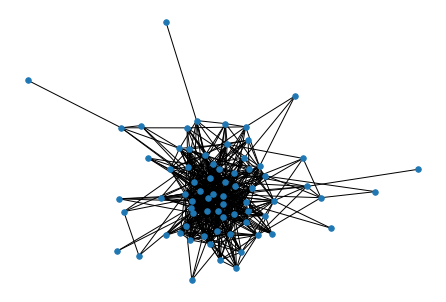

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


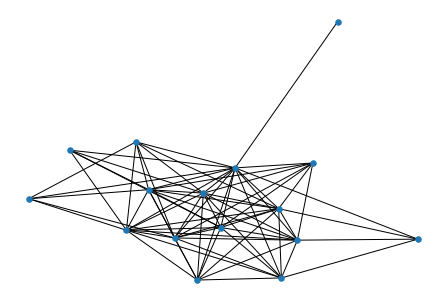

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


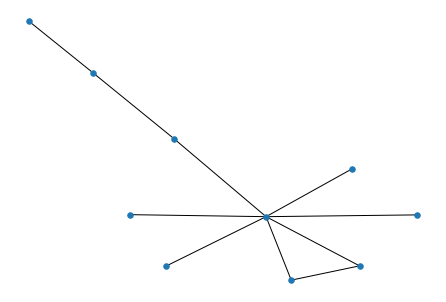

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


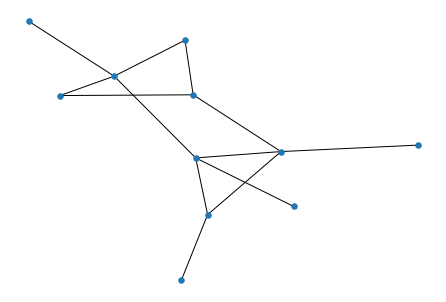

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


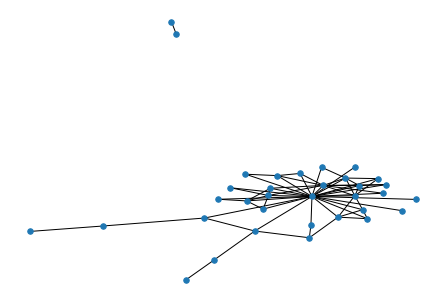

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


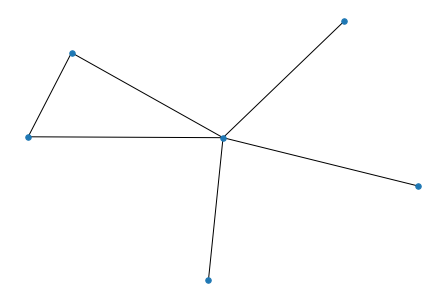

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


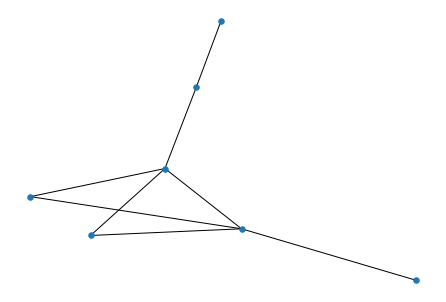

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


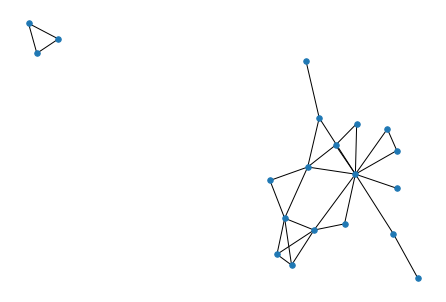

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


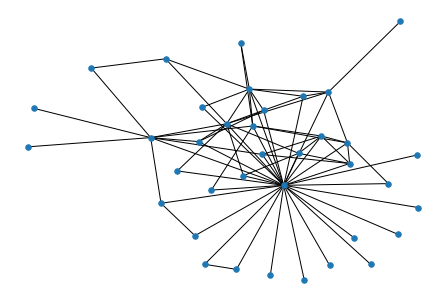

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
empty graph to print
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


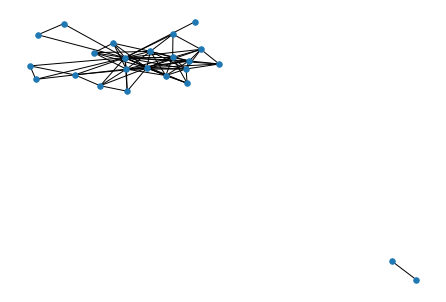

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


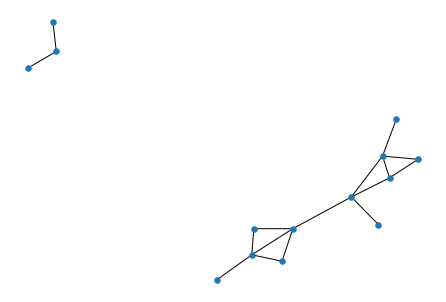

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
empty graph to print


In [8]:
t_adj_mats = [torch.from_numpy(m).float() for m in adj_mats]
t_attr_vecs = torch.eye(len(adj_mats))

for i in range(13):
    print(t_attr_vecs[i])
    a = t_adj_mats[i]
    show_graph(a)

In [0]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [0]:
class Encoder(nn.Module):
    def __init__(self, av_size, d_size, gc_size, z_size, rep_size):
        """

        :param av_size: D_A
        :param d_size: D_X
        :param gc_size: D'
        :param z_size: z
        """
        super(Encoder, self).__init__()
        # input parameters
        self.z_size = z_size
        self.attr_vec = None
        self.gc_size = gc_size
        self.z_size = z_size
        self.d_size = d_size
        self.av_size = av_size
        self.rep_size = rep_size
        
        self.gc = GraphConvolution(d_size + av_size, gc_size)
        self.gc_mu = GraphConvolution(gc_size, z_size)
        self.gc_logvar = GraphConvolution(gc_size, z_size)
        
        self.mean = nn.Sequential( nn.Linear(gc_size, z_size))

        self.logvar = nn.Sequential(nn.Linear(gc_size, z_size)) #nn.ReLU(),
     
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec

    def forward(self, adj):
        x = get_spectral_embedding(adj, d=self.d_size)
        adj = normalize(adj)
        x = cat_attr(x, self.attr_vec)
        x = F.relu(self.gc(x, adj))
        x = F.dropout(x, p=0.5)
        
        #z_mean = self.gc_mu(x, adj)
        #z_logvar = self.gc_logvar(x, adj)
        
        
        # create graph embedding N*D' -> 1*D'
        # x = x.sum(0)
        z_mean = self.mean(x)
        z_logvar = self.logvar(x)
        
        # feature III here
        # z_mean = torch.mean(z_mean, 0)
        # z_mean = z_mean.repeat(z_logvar.shape[0], 1)

        return z_mean, z_logvar

In [0]:
class Decoder(nn.Module):
    def __init__(self, z_out_size, rep_size):
        """
        :param z_out_size: = z_size + len(attr_vec)
        """
        super(Decoder, self).__init__()
        self.z_out_size = z_out_size
        self.rep_size = rep_size

        self.decode = nn.Sequential(
            nn.Linear(z_out_size, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU())

        self.decode = nn.Sequential(
            #nn.Linear(z_out_size, self.rep_size),
            #nn.BatchNorm1d(self.rep_size),
            #nn.ReLU(),
            nn.Linear(z_out_size, int(self.rep_size)),
            nn.BatchNorm1d(int(self.rep_size)),
            nn.ReLU(),
            nn.Linear(int(self.rep_size), int(self.rep_size/2)),
            #nn.BatchNorm1d(int(self.rep_size/2)),
            nn.ReLU()
            )#nn.BatchNorm1d(int(self.rep_size/4)),

        
    def forward(self, z):
        x = self.decode(z)
        # x = z
        x = torch.mm(x, x.t())
        #x = F.sigmoid(x)
        return x

In [0]:
class Generator(nn.Module):
    def __init__(self, av_size, d_size, gc_size, z_size, z_out_size, rep_size):
        """

        :param av_size: D_A
        :param d_size: D_X
        :param gc_size: D' = GCN(D_X + D_A)
        :param z_size: original z size
        :param z_out_size: z size + D_A (append attribute)
        """
        super(Generator, self).__init__()
        self.attr_vec = None
        self.av_size = av_size
        self.d_zize = d_size
        self.z_size = z_size
        self.z_out_size = z_out_size
        self.rep_size = rep_size

        self.encoder = Encoder(av_size, d_size, gc_size, z_size, rep_size)
        self.decoder = Decoder(z_out_size,rep_size)
    
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec
        self.encoder.set_attr_vec(attr_vec)
   
    def forward(self, adj, training=True):
        mean, logvar = self.encoder(adj)
        if(training):
            std = logvar.mul(0.5).exp_()
            reparametrized_noise = torch.randn(mean.shape, requires_grad=True).cuda()
            reparametrized_noise = mean + std * reparametrized_noise
        else:
            reparametrized_noise = mean
            # print('mean',mean)
        x = cat_attr(reparametrized_noise, self.attr_vec)
        rec_x = self.decoder(x)
        return mean, logvar, rec_x

In [0]:
class Discriminator(nn.Module):
    def __init__(self, av_size, d_size, gc_size, rep_size):
        super(Discriminator, self).__init__()
        self.av_size = av_size
        self.attr_vec = None
        self.d_size = d_size
        self.gc_size = gc_size
        self.rep_size = rep_size
        self.gc = GraphConvolution(d_size + av_size, gc_size)
        self.gc2 = GraphConvolution(gc_size, 8)
        
        self.main = nn.Sequential(
            nn.Linear(gc_size, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
        )

        self.sigmoid_output = nn.Sequential(
            nn.Linear(8, 1),
            nn.Sigmoid())
    
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec

    def forward(self, adj):
        # get spectral embedding from adj, D = D_X
        x = get_spectral_embedding(adj, d=self.d_size)
        adj = normalize(adj)
        x = cat_attr(x, self.attr_vec)

        # GCN layer N*D -> N*D'
        x = F.relu(self.gc(x, adj))
        # x = F.relu(self.gc2(x, adj))
        
        # x = F.dropout(x, p=0.5)
        x = self.main(x)
        x = x.sum(0)
        
        x = self.sigmoid_output(x)

        return x

    def similarity(self, adj):
        # get spectral embedding from adj, D = D_X
        x = get_spectral_embedding(adj, d=self.d_size)
        
        # norm adj
        adj = normalize(adj)

        # concatenate attr mat, D = D_X + D_A
        x = cat_attr(x, self.attr_vec)

        # GCN layer N*D -> N*D'
        x = F.relu(self.gc(x, adj))
        x = F.dropout(x, p=0.5)
        #x = F.relu(self.gc2(x, adj))
        # create graph embedding N*D' -> 1*D'
        x = self.main(x)
        # x = x.sum(0)
        # skip the last sigmoid layer
        # x = self.main(x)
        
        return x

In [0]:
def sample_adj(adj):
    adj_sample = adj.data.cpu()
    for i in range(adj.size(0)):
        for j in range(adj.size(1)):
            a = torch.bernoulli(adj.data[i, j])
            adj_sample[i, j] = a
    adj_sample = torch.min(adj_sample, adj_sample.t())
    return adj_sample.cuda()

In [0]:
def top_n_indexes(arr, n):
    idx = np.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]

def topk_adj(adj, k):
    adj_ = adj.data.cpu().numpy()
    assert((adj_ == adj_.T).all())
    adj_ = (adj_-np.min(adj_)) / np.ptp(adj_)
    adj_ -= np.diag(np.diag(adj_))
    inds = top_n_indexes(adj_, k)
    res = torch.zeros(adj.shape)
    for ind in inds:
        res[ind] = 1.0
    return res.cuda()

encoder.gc.weight        torch.Size([50, 16])
encoder.gc.bias        torch.Size([16])
encoder.gc_mu.weight        torch.Size([16, 2])
encoder.gc_mu.bias        torch.Size([2])
encoder.gc_logvar.weight        torch.Size([16, 2])
encoder.gc_logvar.bias        torch.Size([2])
encoder.mean.0.weight        torch.Size([2, 16])
encoder.mean.0.bias        torch.Size([2])
encoder.logvar.0.weight        torch.Size([2, 16])
encoder.logvar.0.bias        torch.Size([2])
decoder.decode.0.weight        torch.Size([16, 2])
decoder.decode.0.bias        torch.Size([16])
decoder.decode.1.weight        torch.Size([16])
decoder.decode.1.bias        torch.Size([16])
decoder.decode.3.weight        torch.Size([8, 16])
decoder.decode.3.bias        torch.Size([8])
[0/2000]: vae_loss:3.1112, prior_loss:3.0739
max tensor(2.0745, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0403, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5449, 0.5299, 0.5313,  ..., 0.5386, 0.5386, 0.5428],
   

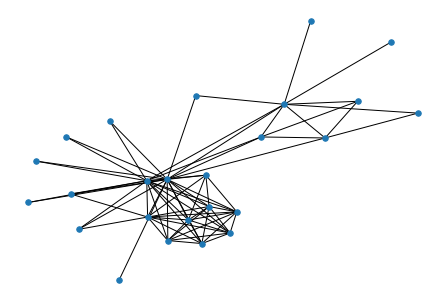

{'LCC': 25,
 'claw_count': 2532.0,
 'cpl': 1.9533333333333334,
 'd': 5.92,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.34756756756756757,
 'n_components': 1,
 'node_num': 25,
 'power_law_exp': 1.6998994007217647,
 'rel_edge_distr_entropy': 0.9048649725153152,
 'square_count': 151,
 'triangle_count': 121,
 'wedge_count': 659.0}


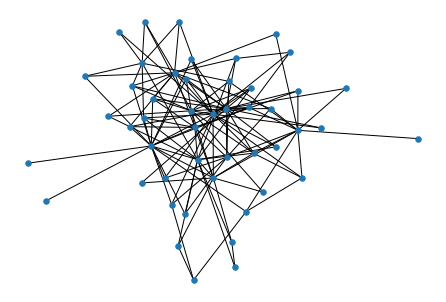

{'LCC': 48,
 'claw_count': 4486.0,
 'cpl': 2.25177304964539,
 'd': 5.541666666666667,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 133,
 'gini': 0.37312030075187974,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.7041798050088959,
 'rel_edge_distr_entropy': 0.9233798590514242,
 'square_count': 6,
 'triangle_count': 62,
 'wedge_count': 1140.0}
[30/2000]: vae_loss:2.3937, prior_loss:1.3101
max tensor(2.9173, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0425, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.6644, 0.5328, 0.5497,  ..., 0.5357, 0.5339, 0.6553],
        [0.5328, 0.5231, 0.5215,  ..., 0.5192, 0.5200, 0.5301],
        [0.5497, 0.5215, 0.5286,  ..., 0.5249, 0.5239, 0.5496],
        ...,
        [0.5357, 0.5192, 0.5249,  ..., 0.5226, 0.5216, 0.5364],
        [0.5339, 0.5200, 0.5239,  ..., 0.5216, 0.5214, 0.5338],
        [0.6553, 0.5301, 0.5496,  ..., 0.5364, 0.5338, 0.6485]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


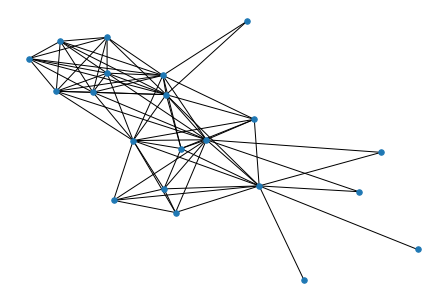

{'LCC': 21,
 'claw_count': 1762.0,
 'cpl': 1.819047619047619,
 'd': 7.0476190476190474,
 'd_max': 14.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.22329472329472333,
 'n_components': 1,
 'node_num': 21,
 'power_law_exp': 1.5846996258039645,
 'rel_edge_distr_entropy': 0.9415949063182257,
 'square_count': 142,
 'triangle_count': 132,
 'wedge_count': 612.0}


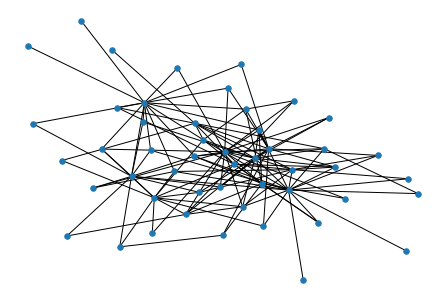

{'LCC': 49,
 'claw_count': 3632.0,
 'cpl': 2.3333333333333335,
 'd': 5.387755102040816,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 132,
 'gini': 0.38126159554730976,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7280205337430727,
 'rel_edge_distr_entropy': 0.9249116178974173,
 'square_count': 2,
 'triangle_count': 47,
 'wedge_count': 1054.0}
[60/2000]: vae_loss:2.0048, prior_loss:0.6732
max tensor(2.8695, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0351, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.6152, 0.5365, 0.5335,  ..., 0.5270, 0.5335, 0.5786],
        [0.5365, 0.5260, 0.5241,  ..., 0.5189, 0.5233, 0.5319],
        [0.5335, 0.5241, 0.5224,  ..., 0.5184, 0.5220, 0.5294],
        ...,
        [0.5270, 0.5189, 0.5184,  ..., 0.5426, 0.5192, 0.5217],
        [0.5335, 0.5233, 0.5220,  ..., 0.5192, 0.5229, 0.5288],
        [0.5786, 0.5319, 0.5294,  ..., 0.5217, 0.5288, 0.5571]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


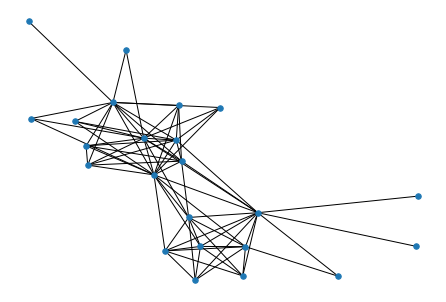

{'LCC': 23,
 'claw_count': 1740.0,
 'cpl': 1.9367588932806323,
 'd': 6.434782608695652,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.26909518213866046,
 'n_components': 1,
 'node_num': 23,
 'power_law_exp': 1.6273785882659146,
 'rel_edge_distr_entropy': 0.9335162912852074,
 'square_count': 97,
 'triangle_count': 113,
 'wedge_count': 591.0}


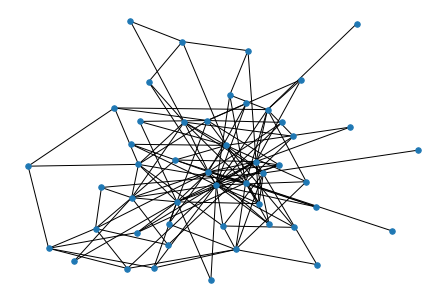

{'LCC': 49,
 'claw_count': 3624.0,
 'cpl': 2.3273809523809526,
 'd': 5.428571428571429,
 'd_max': 22.0,
 'd_min': 1.0,
 'edge_num': 133,
 'gini': 0.33757864047874797,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.690808511448027,
 'rel_edge_distr_entropy': 0.9372736065154945,
 'square_count': 8,
 'triangle_count': 56,
 'wedge_count': 1016.0}
[90/2000]: vae_loss:1.8735, prior_loss:0.4106
max tensor(2.3157, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0321, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5233, 0.5329, 0.5392,  ..., 0.5168, 0.5221, 0.5277],
        [0.5329, 0.5749, 0.6051,  ..., 0.5209, 0.5291, 0.5487],
        [0.5392, 0.6051, 0.6522,  ..., 0.5269, 0.5337, 0.5630],
        ...,
        [0.5168, 0.5209, 0.5269,  ..., 0.5396, 0.5166, 0.5153],
        [0.5221, 0.5291, 0.5337,  ..., 0.5166, 0.5212, 0.5255],
        [0.5277, 0.5487, 0.5630,  ..., 0.5153, 0.5255, 0.5376]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


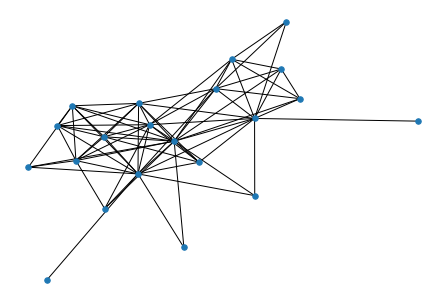

{'LCC': 21,
 'claw_count': 2095.0,
 'cpl': 1.7380952380952381,
 'd': 7.0476190476190474,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.24710424710424705,
 'n_components': 1,
 'node_num': 21,
 'power_law_exp': 1.584430597752858,
 'rel_edge_distr_entropy': 0.9369046238213203,
 'square_count': 128,
 'triangle_count': 127,
 'wedge_count': 642.0}


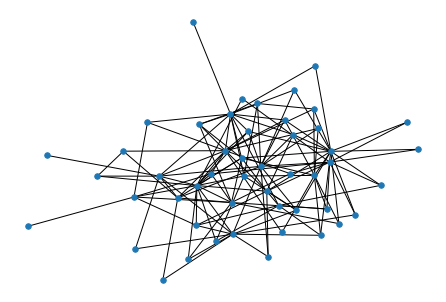

{'LCC': 49,
 'claw_count': 2963.0,
 'cpl': 2.3409863945578233,
 'd': 5.469387755102041,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.33749619250685337,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6879871242444187,
 'rel_edge_distr_entropy': 0.9402764177055257,
 'square_count': 1,
 'triangle_count': 42,
 'wedge_count': 978.0}
[120/2000]: vae_loss:1.7663, prior_loss:0.2902
max tensor(2.0421, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0311, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5569, 0.5908, 0.5375,  ..., 0.5244, 0.5308, 0.5391],
        [0.5908, 0.6572, 0.5641,  ..., 0.5351, 0.5459, 0.5545],
        [0.5375, 0.5641, 0.6631,  ..., 0.6055, 0.5554, 0.5256],
        ...,
        [0.5244, 0.5351, 0.6055,  ..., 0.5719, 0.5370, 0.5197],
        [0.5308, 0.5459, 0.5554,  ..., 0.5370, 0.5320, 0.5234],
        [0.5391, 0.5545, 0.5256,  ..., 0.5197, 0.5234, 0.5315]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


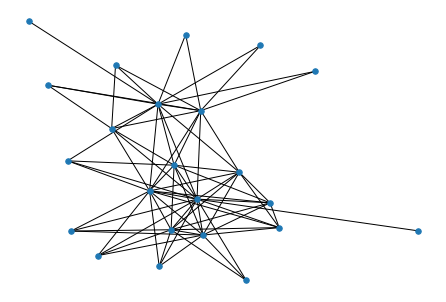

{'LCC': 23,
 'claw_count': 2018.0,
 'cpl': 1.9209486166007905,
 'd': 6.434782608695652,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.2967097532314924,
 'n_components': 1,
 'node_num': 23,
 'power_law_exp': 1.6340607537131406,
 'rel_edge_distr_entropy': 0.9239905813080395,
 'square_count': 98,
 'triangle_count': 112,
 'wedge_count': 628.0}


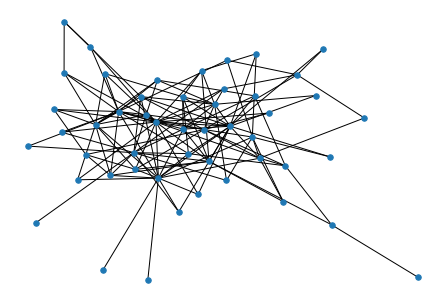

{'LCC': 49,
 'claw_count': 3611.0,
 'cpl': 2.3554421768707483,
 'd': 5.551020408163265,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 136,
 'gini': 0.3523409363745498,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6912803402362828,
 'rel_edge_distr_entropy': 0.9346240243888707,
 'square_count': 6,
 'triangle_count': 59,
 'wedge_count': 1061.0}
[150/2000]: vae_loss:1.7851, prior_loss:0.1867
max tensor(2.1343, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0254, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5332, 0.5281, 0.5259,  ..., 0.5358, 0.5255, 0.5252],
        [0.5281, 0.5258, 0.5240,  ..., 0.5294, 0.5209, 0.5235],
        [0.5259, 0.5240, 0.5223,  ..., 0.5271, 0.5198, 0.5220],
        ...,
        [0.5358, 0.5294, 0.5271,  ..., 0.5391, 0.5274, 0.5263],
        [0.5255, 0.5209, 0.5198,  ..., 0.5274, 0.5817, 0.5201],
        [0.5252, 0.5235, 0.5220,  ..., 0.5263, 0.5201, 0.5221]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


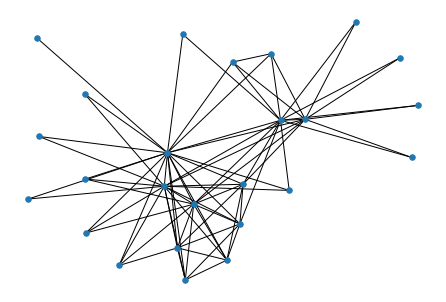

{'LCC': 25,
 'claw_count': 2687.0,
 'cpl': 1.8866666666666667,
 'd': 5.92,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.3545945945945945,
 'n_components': 1,
 'node_num': 25,
 'power_law_exp': 1.6893495407819086,
 'rel_edge_distr_entropy': 0.9031909297142096,
 'square_count': 87,
 'triangle_count': 102,
 'wedge_count': 677.0}


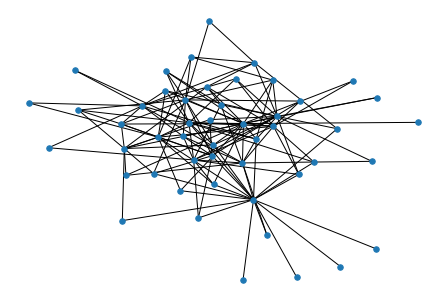

{'LCC': 49,
 'claw_count': 3835.0,
 'cpl': 2.2780612244897958,
 'd': 5.591836734693878,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 137,
 'gini': 0.3733055265901981,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7055680065531522,
 'rel_edge_distr_entropy': 0.9283893627437253,
 'square_count': 0,
 'triangle_count': 53,
 'wedge_count': 1107.0}
[180/2000]: vae_loss:1.6880, prior_loss:0.1335
max tensor(2.2095, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0428, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5916, 0.5538, 0.5301,  ..., 0.5261, 0.5569, 0.6112],
        [0.5538, 0.5388, 0.5260,  ..., 0.5170, 0.5394, 0.5633],
        [0.5301, 0.5260, 0.5212,  ..., 0.5158, 0.5259, 0.5332],
        ...,
        [0.5261, 0.5170, 0.5158,  ..., 0.5461, 0.5183, 0.5277],
        [0.5569, 0.5394, 0.5259,  ..., 0.5183, 0.5404, 0.5672],
        [0.6112, 0.5633, 0.5332,  ..., 0.5277, 0.5672, 0.6357]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


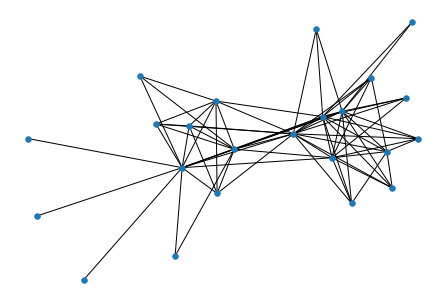

{'LCC': 23,
 'claw_count': 2102.0,
 'cpl': 1.8774703557312253,
 'd': 6.434782608695652,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.29788484136310234,
 'n_components': 1,
 'node_num': 23,
 'power_law_exp': 1.639092571041245,
 'rel_edge_distr_entropy': 0.9223466340821452,
 'square_count': 93,
 'triangle_count': 112,
 'wedge_count': 635.0}


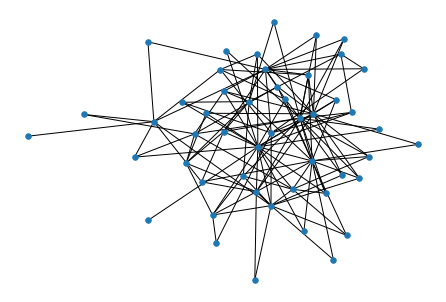

{'LCC': 49,
 'claw_count': 3986.0,
 'cpl': 2.2772108843537415,
 'd': 5.469387755102041,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3530307645446238,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6938717599671165,
 'rel_edge_distr_entropy': 0.9325432041686278,
 'square_count': 2,
 'triangle_count': 36,
 'wedge_count': 1071.0}
[210/2000]: vae_loss:1.6977, prior_loss:0.1059
max tensor(1.4622, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0447, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5710, 0.5837, 0.5483,  ..., 0.5391, 0.5352, 0.5329],
        [0.5837, 0.5997, 0.5553,  ..., 0.5443, 0.5398, 0.5360],
        [0.5483, 0.5553, 0.5374,  ..., 0.5252, 0.5245, 0.5283],
        ...,
        [0.5391, 0.5443, 0.5252,  ..., 0.6556, 0.5847, 0.5222],
        [0.5352, 0.5398, 0.5245,  ..., 0.5847, 0.5528, 0.5205],
        [0.5329, 0.5360, 0.5283,  ..., 0.5222, 0.5205, 0.5239]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


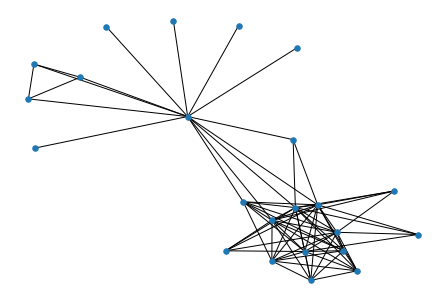

{'LCC': 23,
 'claw_count': 1977.0,
 'cpl': 1.992094861660079,
 'd': 6.434782608695652,
 'd_max': 14.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.30963572267920103,
 'n_components': 1,
 'node_num': 23,
 'power_law_exp': 1.6643554384497214,
 'rel_edge_distr_entropy': 0.9148845047304759,
 'square_count': 185,
 'triangle_count': 140,
 'wedge_count': 637.0}


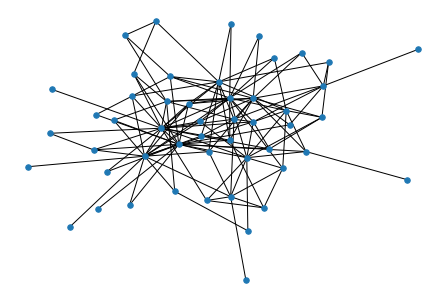

{'LCC': 50,
 'claw_count': 3951.0,
 'cpl': 2.379591836734694,
 'd': 5.36,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.38507462686567173,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7362495865088277,
 'rel_edge_distr_entropy': 0.9235145166934035,
 'square_count': 10,
 'triangle_count': 67,
 'wedge_count': 1086.0}
[240/2000]: vae_loss:1.6608, prior_loss:0.0792
max tensor(1.9472, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0369, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5232, 0.5203, 0.5241,  ..., 0.5191, 0.5205, 0.5319],
        [0.5203, 0.5207, 0.5207,  ..., 0.5341, 0.5225, 0.5271],
        [0.5241, 0.5207, 0.5252,  ..., 0.5182, 0.5209, 0.5334],
        ...,
        [0.5191, 0.5341, 0.5182,  ..., 0.6738, 0.5436, 0.5274],
        [0.5205, 0.5225, 0.5209,  ..., 0.5436, 0.5303, 0.5353],
        [0.5319, 0.5271, 0.5334,  ..., 0.5274, 0.5353, 0.5769]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


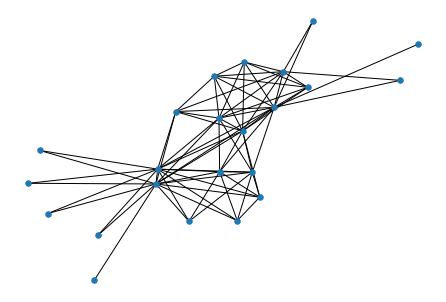

{'LCC': 23,
 'claw_count': 1964.0,
 'cpl': 1.9130434782608696,
 'd': 6.434782608695652,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.2967097532314924,
 'n_components': 1,
 'node_num': 23,
 'power_law_exp': 1.6409835773245165,
 'rel_edge_distr_entropy': 0.9226215289960948,
 'square_count': 113,
 'triangle_count': 118,
 'wedge_count': 625.0}


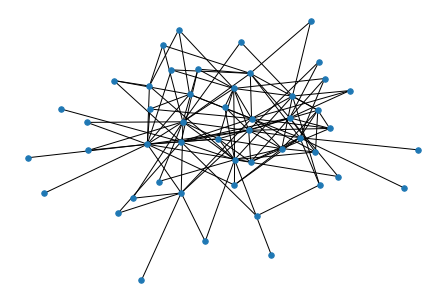

{'LCC': 49,
 'claw_count': 2650.0,
 'cpl': 2.4200680272108843,
 'd': 5.1020408163265305,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 125,
 'gini': 0.38318367346938764,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7683068135934383,
 'rel_edge_distr_entropy': 0.9248348335199615,
 'square_count': 2,
 'triangle_count': 48,
 'wedge_count': 911.0}
[270/2000]: vae_loss:1.7452, prior_loss:0.0600
max tensor(2.2025, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0325, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5365, 0.5544, 0.5538,  ..., 0.5519, 0.5251, 0.5409],
        [0.5544, 0.5991, 0.5977,  ..., 0.5930, 0.5298, 0.5645],
        [0.5538, 0.5977, 0.5962,  ..., 0.5916, 0.5296, 0.5637],
        ...,
        [0.5519, 0.5930, 0.5916,  ..., 0.5873, 0.5292, 0.5613],
        [0.5251, 0.5298, 0.5296,  ..., 0.5292, 0.5226, 0.5267],
        [0.5409, 0.5645, 0.5637,  ..., 0.5613, 0.5267, 0.5467]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


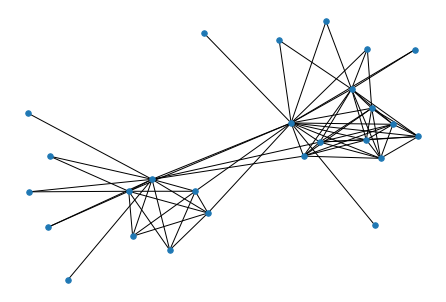

{'LCC': 26,
 'claw_count': 1882.0,
 'cpl': 2.0307692307692307,
 'd': 5.6923076923076925,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.33264033264033266,
 'n_components': 1,
 'node_num': 26,
 'power_law_exp': 1.714105601832139,
 'rel_edge_distr_entropy': 0.9139420011802089,
 'square_count': 120,
 'triangle_count': 111,
 'wedge_count': 589.0}


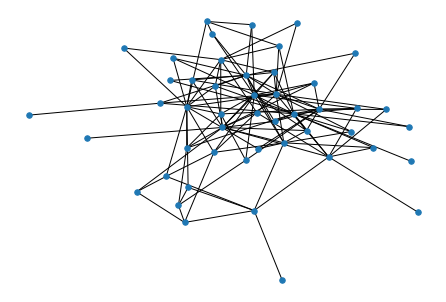

{'LCC': 48,
 'claw_count': 3234.0,
 'cpl': 2.391843971631206,
 'd': 5.375,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 129,
 'gini': 0.35545865633074936,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.7125570741191045,
 'rel_edge_distr_entropy': 0.931707700556222,
 'square_count': 5,
 'triangle_count': 54,
 'wedge_count': 985.0}
[300/2000]: vae_loss:1.6013, prior_loss:0.0542
max tensor(2.4921, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0502, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5337, 0.5501, 0.5302,  ..., 0.5175, 0.5235, 0.5291],
        [0.5501, 0.5940, 0.5407,  ..., 0.5263, 0.5303, 0.5378],
        [0.5302, 0.5407, 0.5281,  ..., 0.5165, 0.5222, 0.5274],
        ...,
        [0.5175, 0.5263, 0.5165,  ..., 0.5793, 0.5142, 0.5163],
        [0.5235, 0.5303, 0.5222,  ..., 0.5142, 0.5221, 0.5218],
        [0.5291, 0.5378, 0.5274,  ..., 0.5163, 0.5218, 0.5268]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


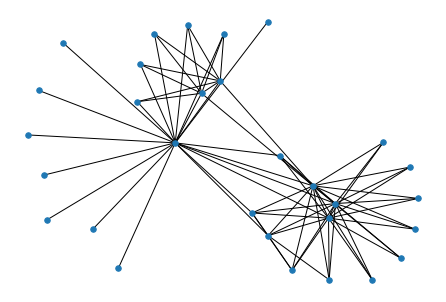

{'LCC': 30,
 'claw_count': 2814.0,
 'cpl': 2.0689655172413794,
 'd': 4.933333333333334,
 'd_max': 21.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.40900900900900883,
 'n_components': 1,
 'node_num': 30,
 'power_law_exp': 1.84605851566571,
 'rel_edge_distr_entropy': 0.8827568413523991,
 'square_count': 45,
 'triangle_count': 79,
 'wedge_count': 659.0}


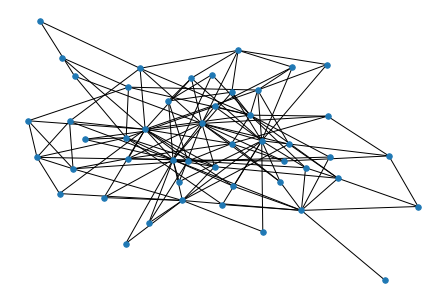

{'LCC': 49,
 'claw_count': 3329.0,
 'cpl': 2.2797619047619047,
 'd': 5.63265306122449,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 138,
 'gini': 0.29148181011535046,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.647235780073054,
 'rel_edge_distr_entropy': 0.950727344479592,
 'square_count': 0,
 'triangle_count': 45,
 'wedge_count': 1004.0}
[330/2000]: vae_loss:1.7103, prior_loss:0.0373
max tensor(2.6666, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0240, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5698, 0.5317, 0.5237,  ..., 0.5397, 0.5580, 0.5296],
        [0.5317, 0.5242, 0.5230,  ..., 0.5237, 0.5284, 0.5212],
        [0.5237, 0.5230, 0.5293,  ..., 0.5186, 0.5220, 0.5177],
        ...,
        [0.5397, 0.5237, 0.5186,  ..., 0.5308, 0.5354, 0.5253],
        [0.5580, 0.5284, 0.5220,  ..., 0.5354, 0.5490, 0.5273],
        [0.5296, 0.5212, 0.5177,  ..., 0.5253, 0.5273, 0.5221]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


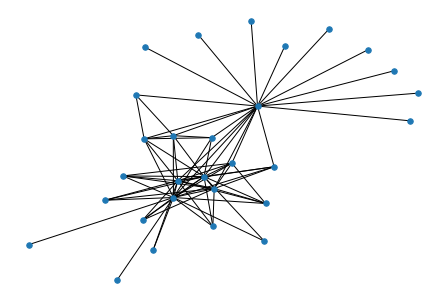

{'LCC': 29,
 'claw_count': 2927.0,
 'cpl': 2.039408866995074,
 'd': 5.103448275862069,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.44454799627213415,
 'n_components': 1,
 'node_num': 29,
 'power_law_exp': 1.8923328047320735,
 'rel_edge_distr_entropy': 0.8666675487977401,
 'square_count': 82,
 'triangle_count': 99,
 'wedge_count': 701.0}


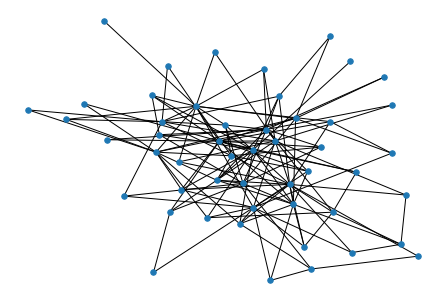

{'LCC': 50,
 'claw_count': 2847.0,
 'cpl': 2.3355102040816327,
 'd': 5.4,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 135,
 'gini': 0.3354074074074074,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.6904274067583898,
 'rel_edge_distr_entropy': 0.9414828023130326,
 'square_count': 0,
 'triangle_count': 38,
 'wedge_count': 966.0}
[360/2000]: vae_loss:1.6369, prior_loss:0.0314
max tensor(3.1887, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0355, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5276, 0.5368, 0.5366,  ..., 0.5182, 0.5200, 0.5233],
        [0.5368, 0.5829, 0.5855,  ..., 0.5286, 0.5356, 0.5297],
        [0.5366, 0.5855, 0.5886,  ..., 0.5322, 0.5380, 0.5299],
        ...,
        [0.5182, 0.5286, 0.5322,  ..., 0.5997, 0.5513, 0.5214],
        [0.5200, 0.5356, 0.5380,  ..., 0.5513, 0.5381, 0.5219],
        [0.5233, 0.5297, 0.5299,  ..., 0.5214, 0.5219, 0.5215]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


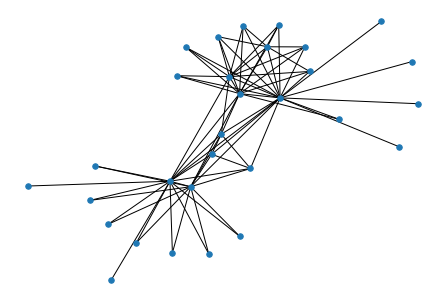

{'LCC': 30,
 'claw_count': 2703.0,
 'cpl': 2.098850574712644,
 'd': 4.933333333333334,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.41981981981981975,
 'n_components': 1,
 'node_num': 30,
 'power_law_exp': 1.848048489915163,
 'rel_edge_distr_entropy': 0.8809280955751351,
 'square_count': 46,
 'triangle_count': 79,
 'wedge_count': 658.0}


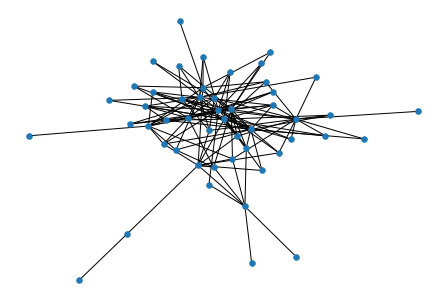

{'LCC': 50,
 'claw_count': 4107.0,
 'cpl': 2.4,
 'd': 5.4,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 135,
 'gini': 0.38844444444444437,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7328921591113682,
 'rel_edge_distr_entropy': 0.9217140175544911,
 'square_count': 8,
 'triangle_count': 57,
 'wedge_count': 1118.0}
[390/2000]: vae_loss:1.6332, prior_loss:0.0240
max tensor(3.0770, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0325, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5352, 0.5762, 0.5273,  ..., 0.5210, 0.5237, 0.5244],
        [0.5762, 0.7426, 0.5419,  ..., 0.5531, 0.5367, 0.5372],
        [0.5273, 0.5419, 0.5245,  ..., 0.5176, 0.5210, 0.5220],
        ...,
        [0.5210, 0.5531, 0.5176,  ..., 0.6148, 0.5211, 0.5210],
        [0.5237, 0.5367, 0.5210,  ..., 0.5211, 0.5189, 0.5196],
        [0.5244, 0.5372, 0.5220,  ..., 0.5210, 0.5196, 0.5208]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


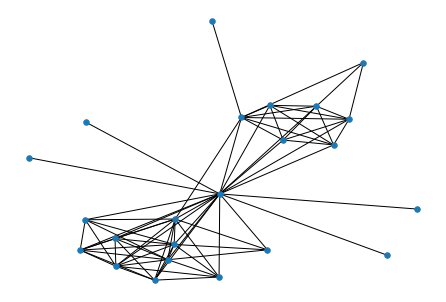

{'LCC': 23,
 'claw_count': 2035.0,
 'cpl': 1.8102766798418972,
 'd': 6.434782608695652,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.2585193889541717,
 'n_components': 1,
 'node_num': 23,
 'power_law_exp': 1.6418563259466388,
 'rel_edge_distr_entropy': 0.9286929918670612,
 'square_count': 150,
 'triangle_count': 131,
 'wedge_count': 610.0}


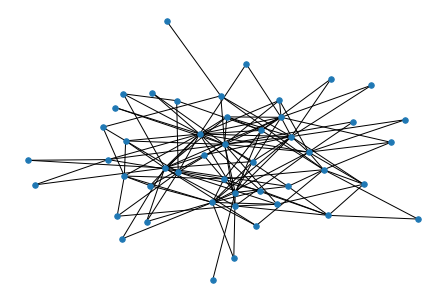

{'LCC': 48,
 'claw_count': 3807.0,
 'cpl': 2.3156028368794326,
 'd': 5.5,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 132,
 'gini': 0.3609532828282829,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.6977741734124425,
 'rel_edge_distr_entropy': 0.9308250417574245,
 'square_count': 14,
 'triangle_count': 66,
 'wedge_count': 1055.0}
[420/2000]: vae_loss:1.6785, prior_loss:0.0206
max tensor(1.9660, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0368, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5341, 0.5283, 0.5741,  ..., 0.5218, 0.5293, 0.5304],
        [0.5283, 0.5263, 0.5444,  ..., 0.5183, 0.5258, 0.5274],
        [0.5741, 0.5444, 0.7542,  ..., 0.5586, 0.5536, 0.5527],
        ...,
        [0.5218, 0.5183, 0.5586,  ..., 0.6012, 0.5206, 0.5191],
        [0.5293, 0.5258, 0.5536,  ..., 0.5206, 0.5263, 0.5272],
        [0.5304, 0.5274, 0.5527,  ..., 0.5191, 0.5272, 0.5288]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


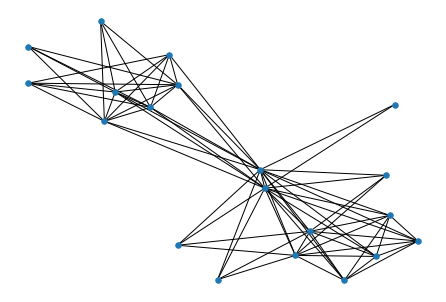

{'LCC': 20,
 'claw_count': 1781.0,
 'cpl': 1.768421052631579,
 'd': 7.4,
 'd_max': 16.0,
 'd_min': 2.0,
 'edge_num': 74,
 'gini': 0.15810810810810816,
 'n_components': 1,
 'node_num': 20,
 'power_law_exp': 1.8395875338140693,
 'rel_edge_distr_entropy': 0.9632081759374905,
 'square_count': 125,
 'triangle_count': 127,
 'wedge_count': 599.0}


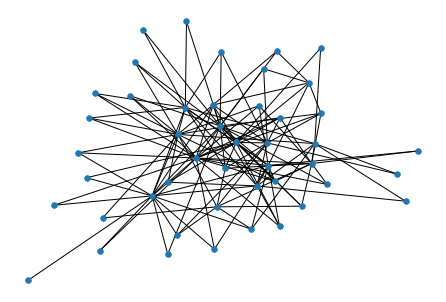

{'LCC': 46,
 'claw_count': 4639.0,
 'cpl': 2.157487922705314,
 'd': 5.826086956521739,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3760545100584036,
 'n_components': 1,
 'node_num': 46,
 'power_law_exp': 1.6811125532817335,
 'rel_edge_distr_entropy': 0.9230641625772578,
 'square_count': 5,
 'triangle_count': 67,
 'wedge_count': 1190.0}
[450/2000]: vae_loss:1.5821, prior_loss:0.0157
max tensor(2.0138, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0393, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5224, 0.5216, 0.5477,  ..., 0.5482, 0.5300, 0.5199],
        [0.5216, 0.5323, 0.5275,  ..., 0.5291, 0.5223, 0.5280],
        [0.5477, 0.5275, 0.7267,  ..., 0.7280, 0.6070, 0.5205],
        ...,
        [0.5482, 0.5291, 0.7280,  ..., 0.7298, 0.6082, 0.5211],
        [0.5300, 0.5223, 0.6070,  ..., 0.6082, 0.5547, 0.5187],
        [0.5199, 0.5280, 0.5205,  ..., 0.5211, 0.5187, 0.5266]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


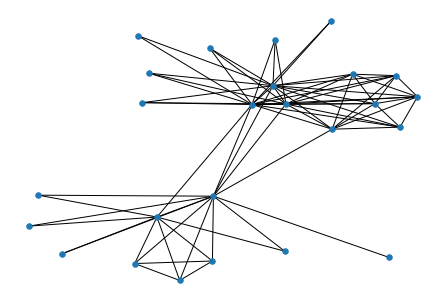

{'LCC': 25,
 'claw_count': 1973.0,
 'cpl': 2.046666666666667,
 'd': 5.92,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.31567567567567556,
 'n_components': 1,
 'node_num': 25,
 'power_law_exp': 1.665607641156487,
 'rel_edge_distr_entropy': 0.9214292308215587,
 'square_count': 103,
 'triangle_count': 106,
 'wedge_count': 602.0}


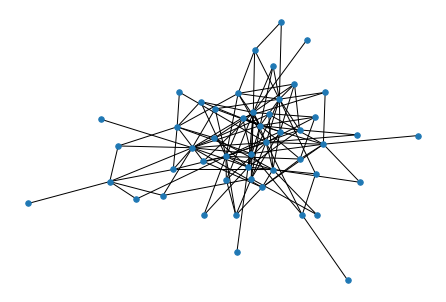

{'LCC': 49,
 'claw_count': 2812.0,
 'cpl': 2.439625850340136,
 'd': 5.3061224489795915,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 130,
 'gini': 0.35149136577707996,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7188700070076357,
 'rel_edge_distr_entropy': 0.9356682581907926,
 'square_count': 1,
 'triangle_count': 44,
 'wedge_count': 938.0}
[480/2000]: vae_loss:1.6279, prior_loss:0.0135
max tensor(2.6880, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0510, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5204, 0.5218, 0.5391,  ..., 0.5246, 0.5287, 0.5343],
        [0.5218, 0.5263, 0.5444,  ..., 0.5303, 0.5343, 0.5402],
        [0.5391, 0.5444, 0.7893,  ..., 0.5879, 0.6573, 0.7318],
        ...,
        [0.5246, 0.5303, 0.5879,  ..., 0.5409, 0.5551, 0.5731],
        [0.5287, 0.5343, 0.6573,  ..., 0.5551, 0.5873, 0.6252],
        [0.5343, 0.5402, 0.7318,  ..., 0.5731, 0.6252, 0.6840]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


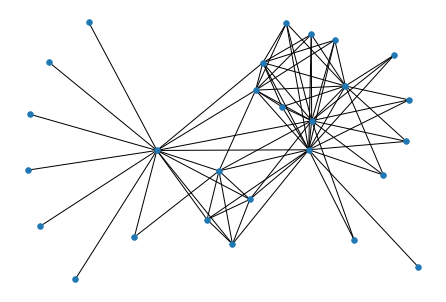

{'LCC': 27,
 'claw_count': 2548.0,
 'cpl': 2.0085470085470085,
 'd': 5.481481481481482,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.3918918918918919,
 'n_components': 1,
 'node_num': 27,
 'power_law_exp': 1.7776863642099836,
 'rel_edge_distr_entropy': 0.8905856216269732,
 'square_count': 75,
 'triangle_count': 98,
 'wedge_count': 660.0}


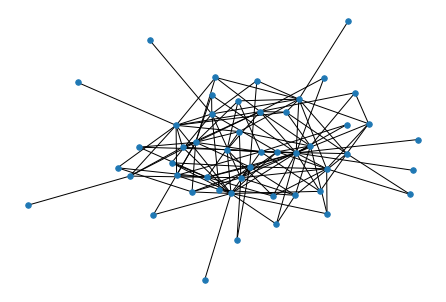

{'LCC': 49,
 'claw_count': 3086.0,
 'cpl': 2.3656462585034013,
 'd': 5.469387755102041,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3495278708498324,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7079613902275899,
 'rel_edge_distr_entropy': 0.9360563642300254,
 'square_count': 3,
 'triangle_count': 56,
 'wedge_count': 991.0}
[510/2000]: vae_loss:1.4387, prior_loss:0.0109
max tensor(1.8198, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0240, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5241, 0.5232, 0.5293,  ..., 0.5250, 0.5519, 0.5198],
        [0.5232, 0.5233, 0.5318,  ..., 0.5279, 0.5438, 0.5213],
        [0.5293, 0.5318, 0.5785,  ..., 0.5614, 0.5760, 0.5303],
        ...,
        [0.5250, 0.5279, 0.5614,  ..., 0.5515, 0.5477, 0.5297],
        [0.5519, 0.5438, 0.5760,  ..., 0.5477, 0.7334, 0.5226],
        [0.5198, 0.5213, 0.5303,  ..., 0.5297, 0.5226, 0.5240]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


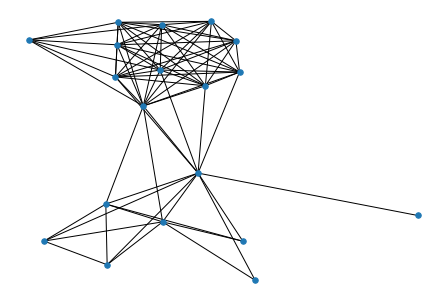

{'LCC': 19,
 'claw_count': 1688.0,
 'cpl': 1.7426900584795322,
 'd': 7.7894736842105265,
 'd_max': 13.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.1443812233285917,
 'n_components': 1,
 'node_num': 19,
 'power_law_exp': 1.5300333871021556,
 'rel_edge_distr_entropy': 0.9594227347486557,
 'square_count': 247,
 'triangle_count': 162,
 'wedge_count': 618.0}


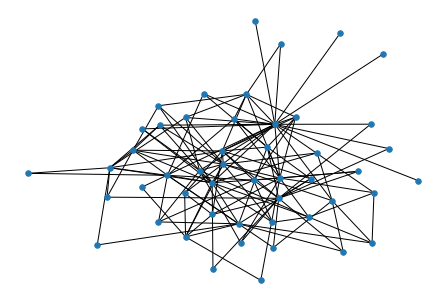

{'LCC': 49,
 'claw_count': 3753.0,
 'cpl': 2.276360544217687,
 'd': 5.551020408163265,
 'd_max': 22.0,
 'd_min': 1.0,
 'edge_num': 136,
 'gini': 0.35219087635054014,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6923409803166054,
 'rel_edge_distr_entropy': 0.9348501946520518,
 'square_count': 7,
 'triangle_count': 66,
 'wedge_count': 1062.0}
[540/2000]: vae_loss:1.5781, prior_loss:0.0078
max tensor(1.6184, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0566, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5610, 0.5290, 0.5483,  ..., 0.5354, 0.5281, 0.5325],
        [0.5290, 0.5229, 0.5407,  ..., 0.5331, 0.5211, 0.5223],
        [0.5483, 0.5407, 0.7545,  ..., 0.6957, 0.5214, 0.5223],
        ...,
        [0.5354, 0.5331, 0.6957,  ..., 0.6496, 0.5191, 0.5200],
        [0.5281, 0.5211, 0.5214,  ..., 0.5191, 0.5216, 0.5237],
        [0.5325, 0.5223, 0.5223,  ..., 0.5200, 0.5237, 0.5270]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


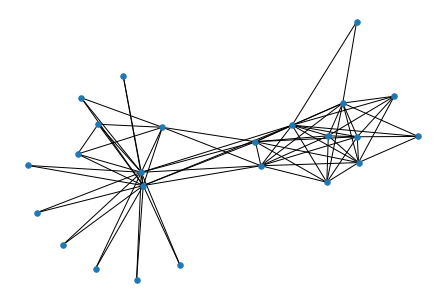

{'LCC': 24,
 'claw_count': 1807.0,
 'cpl': 2.032608695652174,
 'd': 6.166666666666667,
 'd_max': 15.0,
 'd_min': 2.0,
 'edge_num': 74,
 'gini': 0.2888513513513513,
 'n_components': 1,
 'node_num': 24,
 'power_law_exp': 2.145527218378847,
 'rel_edge_distr_entropy': 0.9289848416151519,
 'square_count': 99,
 'triangle_count': 107,
 'wedge_count': 592.0}


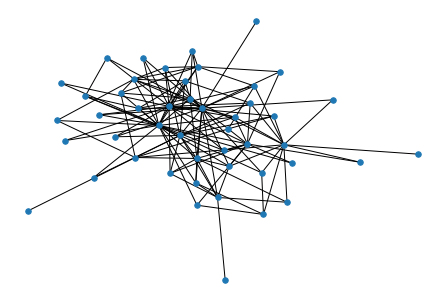

{'LCC': 47,
 'claw_count': 5334.0,
 'cpl': 2.1970397779833486,
 'd': 5.829787234042553,
 'd_max': 22.0,
 'd_min': 1.0,
 'edge_num': 137,
 'gini': 0.37226277372262784,
 'n_components': 1,
 'node_num': 47,
 'power_law_exp': 1.682426484675581,
 'rel_edge_distr_entropy': 0.9239414085654647,
 'square_count': 9,
 'triangle_count': 74,
 'wedge_count': 1239.0}
[570/2000]: vae_loss:1.5775, prior_loss:0.0066
max tensor(1.4884, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0417, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5229, 0.5201, 0.5401,  ..., 0.5181, 0.5215, 0.5293],
        [0.5201, 0.5911, 0.6103,  ..., 0.6094, 0.5201, 0.5382],
        [0.5401, 0.6103, 0.8158,  ..., 0.5996, 0.5390, 0.6251],
        ...,
        [0.5181, 0.6094, 0.5996,  ..., 0.6435, 0.5194, 0.5317],
        [0.5215, 0.5201, 0.5390,  ..., 0.5194, 0.5205, 0.5278],
        [0.5293, 0.5382, 0.6251,  ..., 0.5317, 0.5278, 0.5578]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


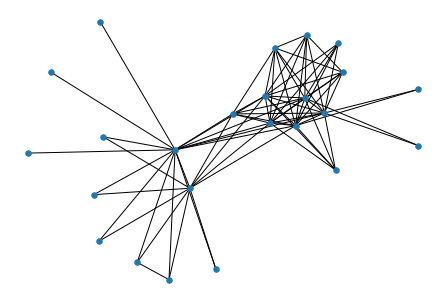

{'LCC': 24,
 'claw_count': 2161.0,
 'cpl': 1.960144927536232,
 'd': 6.25,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 75,
 'gini': 0.3338888888888889,
 'n_components': 1,
 'node_num': 24,
 'power_law_exp': 1.6783342124719791,
 'rel_edge_distr_entropy': 0.9087147905821764,
 'square_count': 141,
 'triangle_count': 126,
 'wedge_count': 659.0}


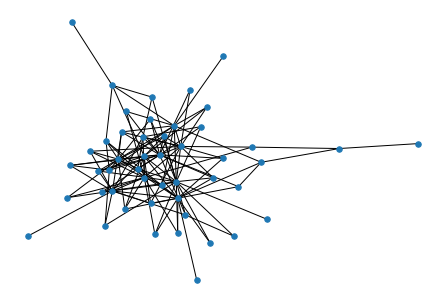

{'LCC': 48,
 'claw_count': 4336.0,
 'cpl': 2.3138297872340425,
 'd': 5.458333333333333,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 131,
 'gini': 0.3786577608142494,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.7241650422500776,
 'rel_edge_distr_entropy': 0.919972462441006,
 'square_count': 2,
 'triangle_count': 48,
 'wedge_count': 1120.0}
[600/2000]: vae_loss:1.6946, prior_loss:0.0058
max tensor(3.4385, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0507, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5220, 0.5329, 0.5195,  ..., 0.5276, 0.5236, 0.5342],
        [0.5329, 0.6406, 0.5750,  ..., 0.5756, 0.5360, 0.6516],
        [0.5195, 0.5750, 0.7221,  ..., 0.5327, 0.5194, 0.5802],
        ...,
        [0.5276, 0.5756, 0.5327,  ..., 0.5479, 0.5301, 0.5808],
        [0.5236, 0.5360, 0.5194,  ..., 0.5301, 0.5255, 0.5375],
        [0.5342, 0.6516, 0.5802,  ..., 0.5808, 0.5375, 0.6635]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


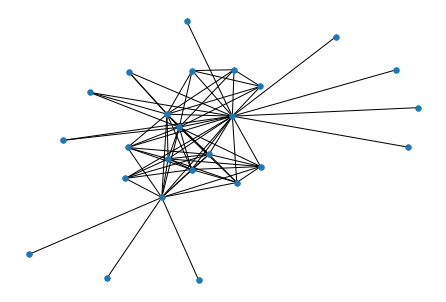

{'LCC': 25,
 'claw_count': 2798.0,
 'cpl': 1.8633333333333333,
 'd': 5.92,
 'd_max': 21.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.3891891891891892,
 'n_components': 1,
 'node_num': 25,
 'power_law_exp': 1.760432268858089,
 'rel_edge_distr_entropy': 0.8853132349150098,
 'square_count': 152,
 'triangle_count': 128,
 'wedge_count': 704.0}


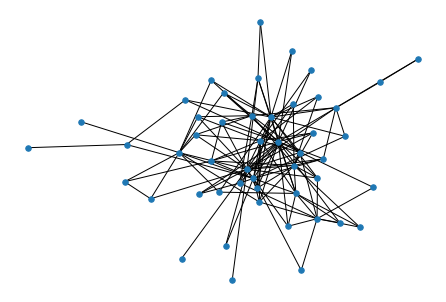

{'LCC': 49,
 'claw_count': 4883.0,
 'cpl': 2.2780612244897958,
 'd': 5.469387755102041,
 'd_max': 22.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3836430094425829,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7178649275913895,
 'rel_edge_distr_entropy': 0.9206141771565195,
 'square_count': 1,
 'triangle_count': 48,
 'wedge_count': 1167.0}
[630/2000]: vae_loss:1.5999, prior_loss:0.0043
max tensor(1.8317, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0513, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5421, 0.5215, 0.5970,  ..., 0.5361, 0.5293, 0.5276],
        [0.5215, 0.5499, 0.5541,  ..., 0.5198, 0.5472, 0.5174],
        [0.5970, 0.5541, 0.8038,  ..., 0.5711, 0.5856, 0.5415],
        ...,
        [0.5361, 0.5198, 0.5711,  ..., 0.5324, 0.5247, 0.5262],
        [0.5293, 0.5472, 0.5856,  ..., 0.5247, 0.5520, 0.5194],
        [0.5276, 0.5174, 0.5415,  ..., 0.5262, 0.5194, 0.5228]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


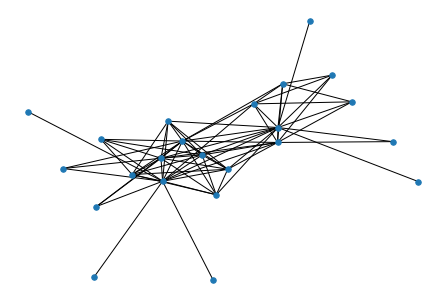

{'LCC': 23,
 'claw_count': 2169.0,
 'cpl': 1.8577075098814229,
 'd': 6.434782608695652,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.3213866039952997,
 'n_components': 1,
 'node_num': 23,
 'power_law_exp': 1.6669829964697314,
 'rel_edge_distr_entropy': 0.9121667036099017,
 'square_count': 133,
 'triangle_count': 126,
 'wedge_count': 653.0}


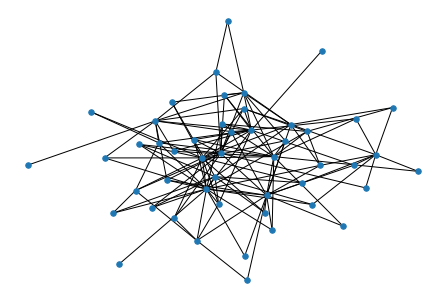

{'LCC': 49,
 'claw_count': 3994.0,
 'cpl': 2.2746598639455784,
 'd': 5.510204081632653,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 135,
 'gini': 0.3584278155706726,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6961225761803367,
 'rel_edge_distr_entropy': 0.930702805874509,
 'square_count': 1,
 'triangle_count': 44,
 'wedge_count': 1091.0}
[660/2000]: vae_loss:1.6701, prior_loss:0.0037
max tensor(3.3459, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0522, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5678, 0.5260, 0.6979,  ..., 0.5251, 0.5315, 0.5316],
        [0.5260, 0.5412, 0.5739,  ..., 0.5533, 0.5443, 0.5436],
        [0.6979, 0.5739, 0.9660,  ..., 0.5794, 0.5983, 0.5983],
        ...,
        [0.5251, 0.5533, 0.5794,  ..., 0.5735, 0.5568, 0.5556],
        [0.5315, 0.5443, 0.5983,  ..., 0.5568, 0.5485, 0.5477],
        [0.5316, 0.5436, 0.5983,  ..., 0.5556, 0.5477, 0.5471]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


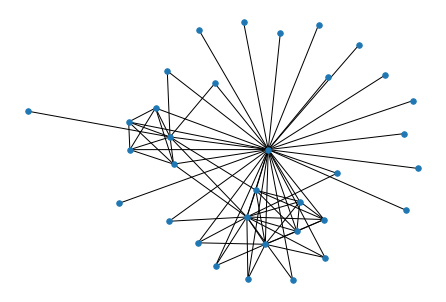

{'LCC': 34,
 'claw_count': 5803.999999999999,
 'cpl': 1.9090909090909092,
 'd': 4.352941176470588,
 'd_max': 32.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.4777424483306838,
 'n_components': 1,
 'node_num': 34,
 'power_law_exp': 2.0435721094225725,
 'rel_edge_distr_entropy': 0.845232571486008,
 'square_count': 56,
 'triangle_count': 77,
 'wedge_count': 819.0}


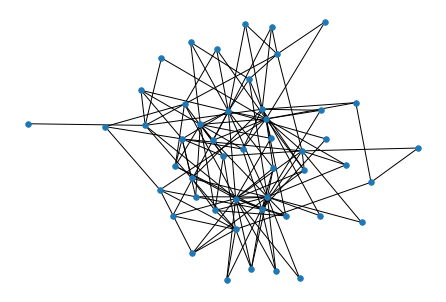

{'LCC': 49,
 'claw_count': 3997.0,
 'cpl': 2.243197278911565,
 'd': 5.673469387755102,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 139,
 'gini': 0.3319630010277492,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6632874367883494,
 'rel_edge_distr_entropy': 0.9395739675992434,
 'square_count': 6,
 'triangle_count': 55,
 'wedge_count': 1101.0}
[690/2000]: vae_loss:1.6461, prior_loss:0.0027
max tensor(1.5995, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0461, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5491, 0.5261, 0.6155,  ..., 0.5209, 0.5267, 0.5431],
        [0.5261, 0.5197, 0.5392,  ..., 0.5176, 0.5203, 0.5249],
        [0.6155, 0.5392, 0.8319,  ..., 0.5505, 0.5394, 0.5935],
        ...,
        [0.5209, 0.5176, 0.5505,  ..., 0.5480, 0.5181, 0.5200],
        [0.5267, 0.5203, 0.5394,  ..., 0.5181, 0.5209, 0.5255],
        [0.5431, 0.5249, 0.5935,  ..., 0.5200, 0.5255, 0.5386]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


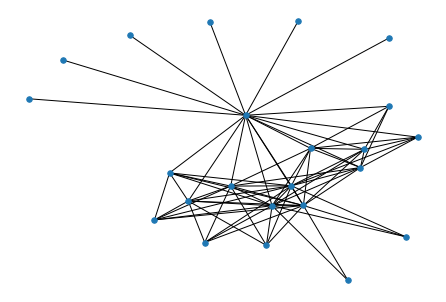

{'LCC': 23,
 'claw_count': 2335.0,
 'cpl': 1.849802371541502,
 'd': 6.434782608695652,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.336662749706228,
 'n_components': 1,
 'node_num': 23,
 'power_law_exp': 1.6852695895332428,
 'rel_edge_distr_entropy': 0.9039952388892852,
 'square_count': 140,
 'triangle_count': 130,
 'wedge_count': 676.0}


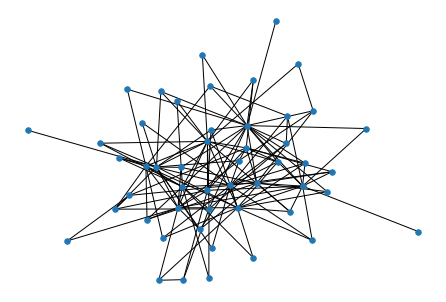

{'LCC': 50,
 'claw_count': 4013.0,
 'cpl': 2.2824489795918366,
 'd': 5.48,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 137,
 'gini': 0.37240875912408766,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7086369801446568,
 'rel_edge_distr_entropy': 0.9268906795883521,
 'square_count': 4,
 'triangle_count': 58,
 'wedge_count': 1119.0}
[720/2000]: vae_loss:1.5283, prior_loss:0.0022
max tensor(1.7525, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0540, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5217, 0.5186, 0.5213,  ..., 0.5181, 0.5224, 0.5198],
        [0.5186, 0.5508, 0.5797,  ..., 0.5601, 0.5177, 0.5608],
        [0.5213, 0.5797, 0.6341,  ..., 0.5958, 0.5202, 0.5991],
        ...,
        [0.5181, 0.5601, 0.5958,  ..., 0.5740, 0.5169, 0.5720],
        [0.5224, 0.5177, 0.5202,  ..., 0.5169, 0.5235, 0.5189],
        [0.5198, 0.5608, 0.5991,  ..., 0.5720, 0.5189, 0.5744]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


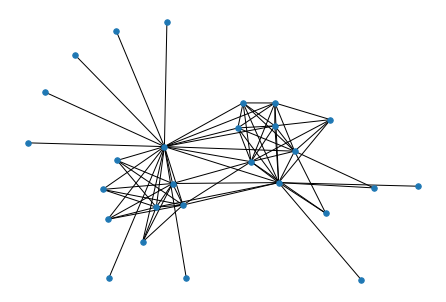

{'LCC': 27,
 'claw_count': 2503.0,
 'cpl': 1.9458689458689458,
 'd': 5.481481481481482,
 'd_max': 21.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.3883883883883885,
 'n_components': 1,
 'node_num': 27,
 'power_law_exp': 1.795896196292968,
 'rel_edge_distr_entropy': 0.8897729514900924,
 'square_count': 106,
 'triangle_count': 109,
 'wedge_count': 651.0}


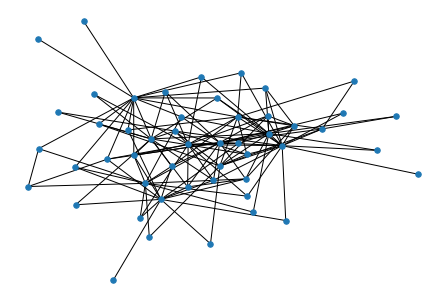

{'LCC': 50,
 'claw_count': 4126.0,
 'cpl': 2.3314285714285714,
 'd': 5.44,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 136,
 'gini': 0.38588235294117634,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7236556976372142,
 'rel_edge_distr_entropy': 0.922482094581455,
 'square_count': 4,
 'triangle_count': 57,
 'wedge_count': 1131.0}
[750/2000]: vae_loss:1.5751, prior_loss:0.0017
max tensor(1.8011, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0435, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5304, 0.5218, 0.5431,  ..., 0.5292, 0.5246, 0.5227],
        [0.5218, 0.5222, 0.5298,  ..., 0.5214, 0.5193, 0.5248],
        [0.5431, 0.5298, 0.6061,  ..., 0.5380, 0.5288, 0.5413],
        ...,
        [0.5292, 0.5214, 0.5380,  ..., 0.5284, 0.5242, 0.5216],
        [0.5246, 0.5193, 0.5288,  ..., 0.5242, 0.5215, 0.5198],
        [0.5227, 0.5248, 0.5413,  ..., 0.5216, 0.5198, 0.5320]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


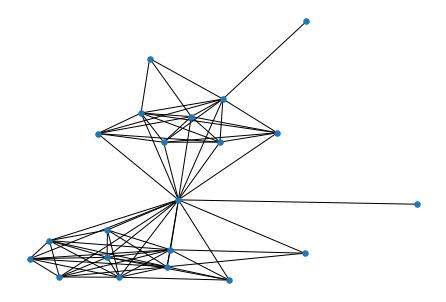

{'LCC': 21,
 'claw_count': 1688.0,
 'cpl': 1.7523809523809524,
 'd': 7.0476190476190474,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.1647361647361647,
 'n_components': 1,
 'node_num': 21,
 'power_law_exp': 1.5631367196638302,
 'rel_edge_distr_entropy': 0.9563015026377271,
 'square_count': 157,
 'triangle_count': 137,
 'wedge_count': 580.0}


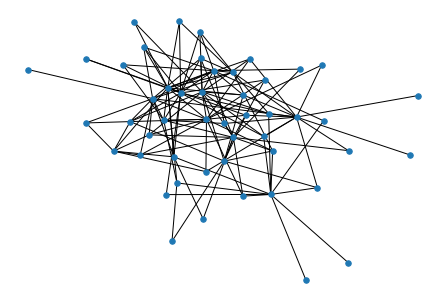

{'LCC': 49,
 'claw_count': 3049.0,
 'cpl': 2.3537414965986394,
 'd': 5.346938775510204,
 'd_max': 14.0,
 'd_min': 1.0,
 'edge_num': 131,
 'gini': 0.36360803863530133,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7216149490256436,
 'rel_edge_distr_entropy': 0.9309752153413232,
 'square_count': 0,
 'triangle_count': 34,
 'wedge_count': 985.0}
[780/2000]: vae_loss:1.6924, prior_loss:0.0014
max tensor(1.6122, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0499, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5380, 0.5236, 0.5249,  ..., 0.5360, 0.5244, 0.5330],
        [0.5236, 0.5197, 0.5201,  ..., 0.5231, 0.5226, 0.5224],
        [0.5249, 0.5201, 0.5217,  ..., 0.5245, 0.5225, 0.5237],
        ...,
        [0.5360, 0.5231, 0.5245,  ..., 0.5343, 0.5232, 0.5318],
        [0.5244, 0.5226, 0.5225,  ..., 0.5232, 0.5473, 0.5220],
        [0.5330, 0.5224, 0.5237,  ..., 0.5318, 0.5220, 0.5297]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


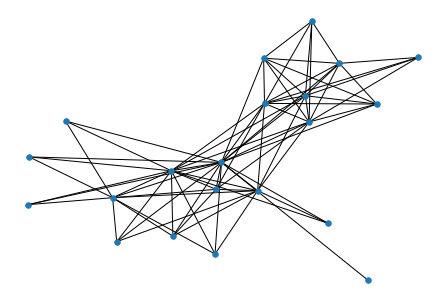

{'LCC': 21,
 'claw_count': 2097.0,
 'cpl': 1.7333333333333334,
 'd': 7.0476190476190474,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.23230373230373225,
 'n_components': 1,
 'node_num': 21,
 'power_law_exp': 1.5696689614500634,
 'rel_edge_distr_entropy': 0.9429595125016288,
 'square_count': 99,
 'triangle_count': 117,
 'wedge_count': 634.0}


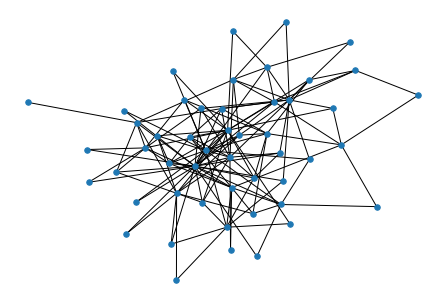

{'LCC': 50,
 'claw_count': 4424.0,
 'cpl': 2.3110204081632655,
 'd': 5.56,
 'd_max': 24.0,
 'd_min': 1.0,
 'edge_num': 139,
 'gini': 0.3519424460431655,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.6862514395886838,
 'rel_edge_distr_entropy': 0.9336529679795302,
 'square_count': 4,
 'triangle_count': 59,
 'wedge_count': 1127.0}
[810/2000]: vae_loss:1.7393, prior_loss:0.0013
max tensor(1.2822, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0486, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5301, 0.5344, 0.5267,  ..., 0.5205, 0.5210, 0.5424],
        [0.5344, 0.5447, 0.5390,  ..., 0.5257, 0.5265, 0.5607],
        [0.5267, 0.5390, 0.6123,  ..., 0.5741, 0.5632, 0.5584],
        ...,
        [0.5205, 0.5257, 0.5741,  ..., 0.5530, 0.5449, 0.5341],
        [0.5210, 0.5265, 0.5632,  ..., 0.5449, 0.5396, 0.5350],
        [0.5424, 0.5607, 0.5584,  ..., 0.5341, 0.5350, 0.5882]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


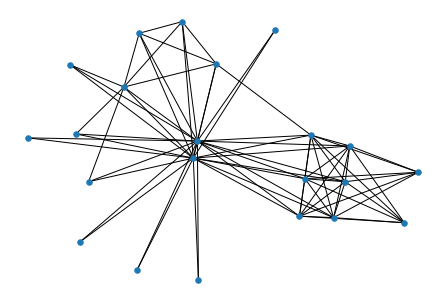

{'LCC': 22,
 'claw_count': 2617.0,
 'cpl': 1.774891774891775,
 'd': 6.7272727272727275,
 'd_max': 19.0,
 'd_min': 2.0,
 'edge_num': 74,
 'gini': 0.27518427518427524,
 'n_components': 1,
 'node_num': 22,
 'power_law_exp': 2.0297930114180667,
 'rel_edge_distr_entropy': 0.9268171562502792,
 'square_count': 129,
 'triangle_count': 122,
 'wedge_count': 674.0}


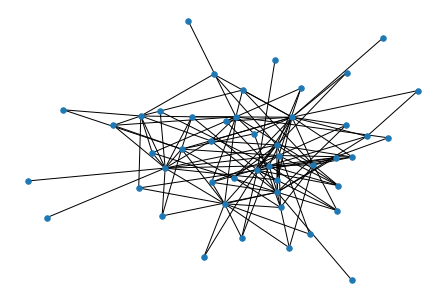

{'LCC': 48,
 'claw_count': 3646.0,
 'cpl': 2.2845744680851063,
 'd': 5.458333333333333,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 131,
 'gini': 0.38263358778625967,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.727089245511207,
 'rel_edge_distr_entropy': 0.9231054648949721,
 'square_count': 0,
 'triangle_count': 50,
 'wedge_count': 1063.0}
[840/2000]: vae_loss:1.5512, prior_loss:0.0009
max tensor(1.2093, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0515, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5219, 0.5229, 0.5228,  ..., 0.5231, 0.5223, 0.5278],
        [0.5229, 0.5261, 0.5209,  ..., 0.5200, 0.5207, 0.5330],
        [0.5228, 0.5209, 0.5344,  ..., 0.5416, 0.5325, 0.5329],
        ...,
        [0.5231, 0.5200, 0.5416,  ..., 0.5578, 0.5395, 0.5319],
        [0.5223, 0.5207, 0.5325,  ..., 0.5395, 0.5309, 0.5303],
        [0.5278, 0.5330, 0.5329,  ..., 0.5319, 0.5303, 0.5658]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


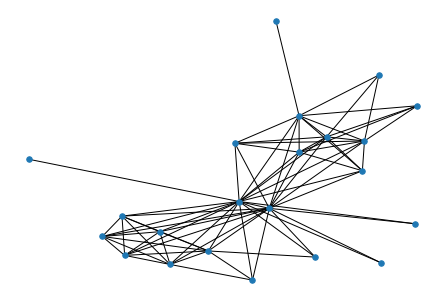

{'LCC': 22,
 'claw_count': 2170.0,
 'cpl': 1.8225108225108224,
 'd': 6.7272727272727275,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.25245700245700253,
 'n_components': 1,
 'node_num': 22,
 'power_law_exp': 1.6027398217113036,
 'rel_edge_distr_entropy': 0.9341086909410404,
 'square_count': 135,
 'triangle_count': 126,
 'wedge_count': 632.0}


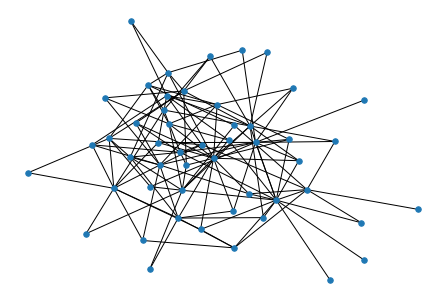

{'LCC': 50,
 'claw_count': 2239.0,
 'cpl': 2.390204081632653,
 'd': 5.16,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 129,
 'gini': 0.3189147286821705,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7066536778941899,
 'rel_edge_distr_entropy': 0.9467211904092835,
 'square_count': 0,
 'triangle_count': 27,
 'wedge_count': 840.0}
[870/2000]: vae_loss:1.6451, prior_loss:0.0008
max tensor(1.3644, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0521, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5216, 0.5213, 0.5215,  ..., 0.5232, 0.5242, 0.5258],
        [0.5213, 0.5213, 0.5209,  ..., 0.5233, 0.5243, 0.5260],
        [0.5215, 0.5209, 0.5997,  ..., 0.5213, 0.5266, 0.5356],
        ...,
        [0.5232, 0.5233, 0.5213,  ..., 0.5258, 0.5270, 0.5289],
        [0.5242, 0.5243, 0.5266,  ..., 0.5270, 0.5304, 0.5354],
        [0.5258, 0.5260, 0.5356,  ..., 0.5289, 0.5354, 0.5449]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


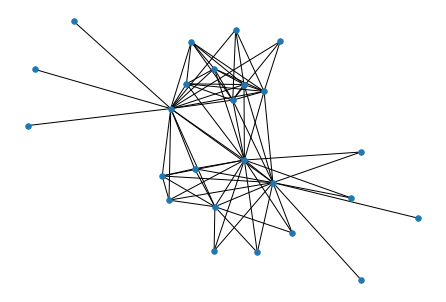

{'LCC': 25,
 'claw_count': 2346.0,
 'cpl': 1.9066666666666667,
 'd': 5.92,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.354054054054054,
 'n_components': 1,
 'node_num': 25,
 'power_law_exp': 1.7094359479675338,
 'rel_edge_distr_entropy': 0.9042026129501713,
 'square_count': 98,
 'triangle_count': 109,
 'wedge_count': 650.0}


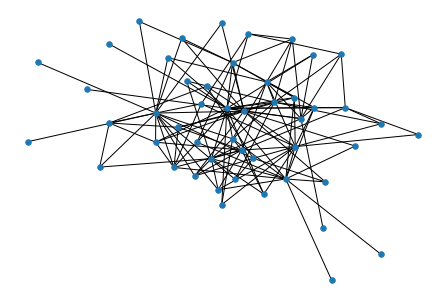

{'LCC': 49,
 'claw_count': 3671.0,
 'cpl': 2.3273809523809526,
 'd': 5.510204081632653,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 135,
 'gini': 0.3650793650793651,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7106544306052822,
 'rel_edge_distr_entropy': 0.9306263721538505,
 'square_count': 2,
 'triangle_count': 57,
 'wedge_count': 1062.0}
[900/2000]: vae_loss:1.6215, prior_loss:0.0005
max tensor(1.2761, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0520, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5214, 0.5273, 0.5210,  ..., 0.5204, 0.5241, 0.5239],
        [0.5273, 0.5728, 0.5332,  ..., 0.5310, 0.5424, 0.5418],
        [0.5210, 0.5332, 0.5337,  ..., 0.5381, 0.5228, 0.5228],
        ...,
        [0.5204, 0.5310, 0.5381,  ..., 0.5465, 0.5211, 0.5211],
        [0.5241, 0.5424, 0.5228,  ..., 0.5211, 0.5314, 0.5310],
        [0.5239, 0.5418, 0.5228,  ..., 0.5211, 0.5310, 0.5306]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


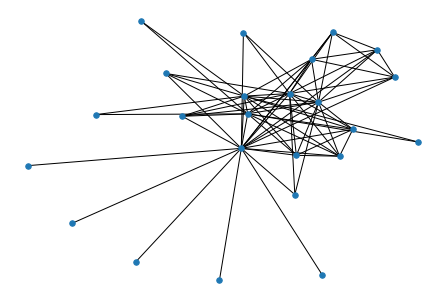

{'LCC': 24,
 'claw_count': 2768.0,
 'cpl': 1.8405797101449275,
 'd': 6.166666666666667,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.36430180180180183,
 'n_components': 1,
 'node_num': 24,
 'power_law_exp': 1.7051028553410867,
 'rel_edge_distr_entropy': 0.8957545032045983,
 'square_count': 130,
 'triangle_count': 122,
 'wedge_count': 703.0}


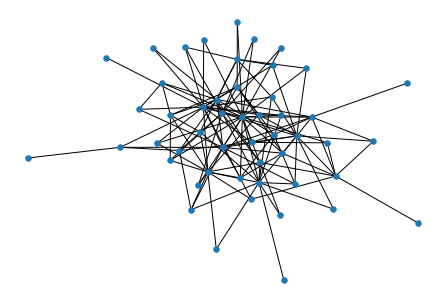

{'LCC': 50,
 'claw_count': 3773.0,
 'cpl': 2.316734693877551,
 'd': 5.28,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 132,
 'gini': 0.37075757575757584,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7279924623449663,
 'rel_edge_distr_entropy': 0.9278392288152244,
 'square_count': 2,
 'triangle_count': 53,
 'wedge_count': 1038.0}
[930/2000]: vae_loss:1.6919, prior_loss:0.0004
max tensor(1.8438, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0698, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5214, 0.5215, 0.5340,  ..., 0.5225, 0.5220, 0.5271],
        [0.5215, 0.5219, 0.5356,  ..., 0.5231, 0.5224, 0.5282],
        [0.5340, 0.5356, 0.7449,  ..., 0.5375, 0.5362, 0.6208],
        ...,
        [0.5225, 0.5231, 0.5375,  ..., 0.5245, 0.5239, 0.5298],
        [0.5220, 0.5224, 0.5362,  ..., 0.5239, 0.5232, 0.5289],
        [0.5271, 0.5282, 0.6208,  ..., 0.5298, 0.5289, 0.5648]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


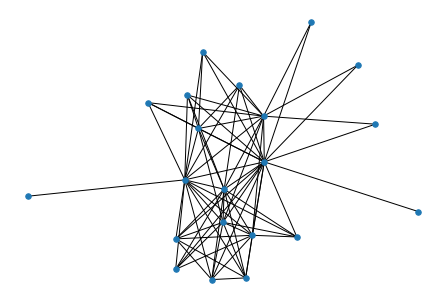

{'LCC': 21,
 'claw_count': 2623.0,
 'cpl': 1.6666666666666667,
 'd': 7.0476190476190474,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.28828828828828823,
 'n_components': 1,
 'node_num': 21,
 'power_law_exp': 1.602199858100133,
 'rel_edge_distr_entropy': 0.9212624988376692,
 'square_count': 138,
 'triangle_count': 131,
 'wedge_count': 701.0}


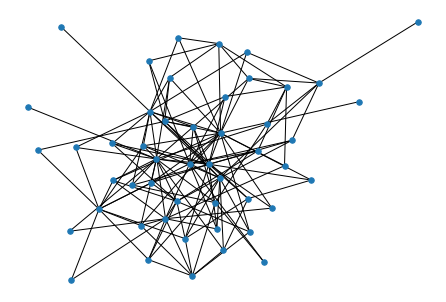

{'LCC': 49,
 'claw_count': 3351.0,
 'cpl': 2.318877551020408,
 'd': 5.673469387755102,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 139,
 'gini': 0.3206577595066804,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6658804206808187,
 'rel_edge_distr_entropy': 0.9436429005600904,
 'square_count': 1,
 'triangle_count': 42,
 'wedge_count': 1042.0}
[960/2000]: vae_loss:1.7154, prior_loss:0.0004
max tensor(1.8151, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0615, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5218, 0.5281, 0.5214,  ..., 0.5222, 0.5215, 0.5220],
        [0.5281, 0.5886, 0.5280,  ..., 0.5294, 0.5279, 0.5287],
        [0.5214, 0.5280, 0.5217,  ..., 0.5215, 0.5213, 0.5213],
        ...,
        [0.5222, 0.5294, 0.5215,  ..., 0.5231, 0.5217, 0.5227],
        [0.5215, 0.5279, 0.5213,  ..., 0.5217, 0.5213, 0.5215],
        [0.5220, 0.5287, 0.5213,  ..., 0.5227, 0.5215, 0.5224]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


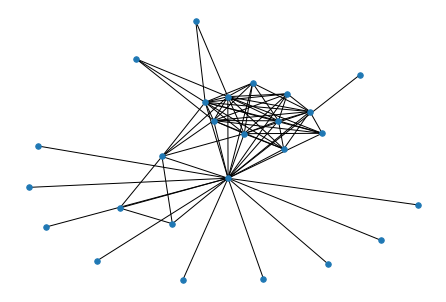

{'LCC': 26,
 'claw_count': 3146.0,
 'cpl': 1.8461538461538463,
 'd': 5.6923076923076925,
 'd_max': 23.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.41891891891891886,
 'n_components': 1,
 'node_num': 26,
 'power_law_exp': 1.8261337936189297,
 'rel_edge_distr_entropy': 0.8692516901066465,
 'square_count': 187,
 'triangle_count': 137,
 'wedge_count': 735.0}


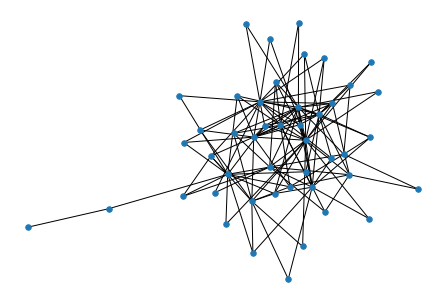

{'LCC': 46,
 'claw_count': 4487.0,
 'cpl': 2.276328502415459,
 'd': 5.608695652173913,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 129,
 'gini': 0.3845635321873946,
 'n_components': 1,
 'node_num': 46,
 'power_law_exp': 1.7045789235388242,
 'rel_edge_distr_entropy': 0.9193103006566108,
 'square_count': 18,
 'triangle_count': 74,
 'wedge_count': 1134.0}
[990/2000]: vae_loss:1.6919, prior_loss:0.0004
max tensor(1.5594, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0561, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5229, 0.5205, 0.5310,  ..., 0.5200, 0.5248, 0.5229],
        [0.5205, 0.5239, 0.5362,  ..., 0.5235, 0.5224, 0.5205],
        [0.5310, 0.5362, 0.6515,  ..., 0.5327, 0.5432, 0.5310],
        ...,
        [0.5200, 0.5235, 0.5327,  ..., 0.5234, 0.5217, 0.5200],
        [0.5248, 0.5224, 0.5432,  ..., 0.5217, 0.5279, 0.5248],
        [0.5229, 0.5205, 0.5310,  ..., 0.5200, 0.5248, 0.5229]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


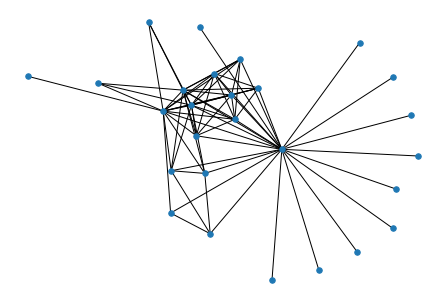

{'LCC': 27,
 'claw_count': 3202.0,
 'cpl': 1.8831908831908832,
 'd': 5.481481481481482,
 'd_max': 23.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.4314314314314316,
 'n_components': 1,
 'node_num': 27,
 'power_law_exp': 1.8525822868564314,
 'rel_edge_distr_entropy': 0.8672610410675493,
 'square_count': 157,
 'triangle_count': 125,
 'wedge_count': 730.0}


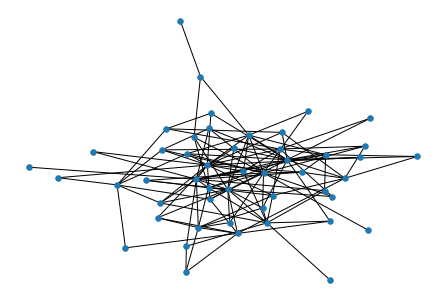

{'LCC': 49,
 'claw_count': 3188.0,
 'cpl': 2.3979591836734695,
 'd': 5.428571428571429,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 133,
 'gini': 0.3389596440079792,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6940569800798486,
 'rel_edge_distr_entropy': 0.9387363652947793,
 'square_count': 0,
 'triangle_count': 38,
 'wedge_count': 985.0}
[1020/2000]: vae_loss:1.7389, prior_loss:0.0004
max tensor(0.6557, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0716, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5249, 0.5226, 0.5249,  ..., 0.5249, 0.5206, 0.5273],
        [0.5226, 0.5215, 0.5226,  ..., 0.5226, 0.5211, 0.5247],
        [0.5249, 0.5226, 0.5249,  ..., 0.5249, 0.5206, 0.5273],
        ...,
        [0.5249, 0.5226, 0.5249,  ..., 0.5249, 0.5206, 0.5273],
        [0.5206, 0.5211, 0.5206,  ..., 0.5206, 0.5266, 0.5248],
        [0.5273, 0.5247, 0.5273,  ..., 0.5273, 0.5248, 0.5405]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


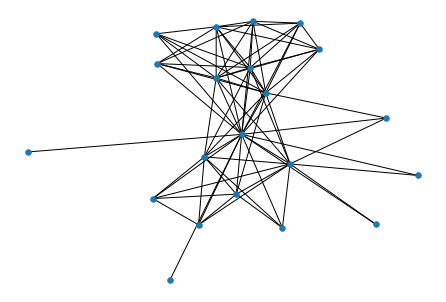

{'LCC': 21,
 'claw_count': 2360.0,
 'cpl': 1.6476190476190475,
 'd': 7.0476190476190474,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.25482625482625476,
 'n_components': 1,
 'node_num': 21,
 'power_law_exp': 1.5891549338224102,
 'rel_edge_distr_entropy': 0.9325528099668914,
 'square_count': 137,
 'triangle_count': 130,
 'wedge_count': 663.0}


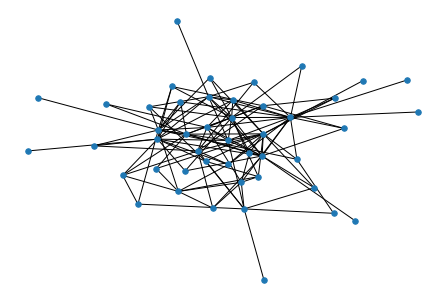

{'LCC': 46,
 'claw_count': 3077.0,
 'cpl': 2.322705314009662,
 'd': 5.478260869565218,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 126,
 'gini': 0.3693926846100759,
 'n_components': 1,
 'node_num': 46,
 'power_law_exp': 1.7235566698842482,
 'rel_edge_distr_entropy': 0.9278014284426436,
 'square_count': 14,
 'triangle_count': 52,
 'wedge_count': 973.0}
[1050/2000]: vae_loss:1.6448, prior_loss:0.0002
max tensor(1.6542, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0642, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5230, 0.5197, 0.5371,  ..., 0.5225, 0.5215, 0.5258],
        [0.5197, 0.5295, 0.5600,  ..., 0.5196, 0.5220, 0.5243],
        [0.5371, 0.5600, 0.8395,  ..., 0.5357, 0.5368, 0.5880],
        ...,
        [0.5225, 0.5196, 0.5357,  ..., 0.5221, 0.5212, 0.5251],
        [0.5215, 0.5220, 0.5368,  ..., 0.5212, 0.5214, 0.5240],
        [0.5258, 0.5243, 0.5880,  ..., 0.5251, 0.5240, 0.5357]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


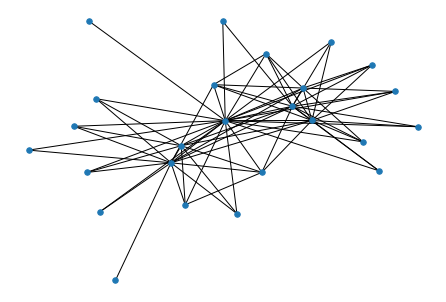

{'LCC': 25,
 'claw_count': 3322.0,
 'cpl': 1.7833333333333334,
 'd': 5.92,
 'd_max': 23.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.3572972972972972,
 'n_components': 1,
 'node_num': 25,
 'power_law_exp': 1.6906397202817889,
 'rel_edge_distr_entropy': 0.897410449856421,
 'square_count': 62,
 'triangle_count': 94,
 'wedge_count': 723.0}


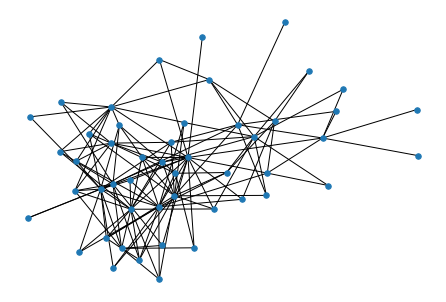

{'LCC': 49,
 'claw_count': 3237.0,
 'cpl': 2.395408163265306,
 'd': 5.510204081632653,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 135,
 'gini': 0.3357520786092214,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6860675916712609,
 'rel_edge_distr_entropy': 0.9396411153671766,
 'square_count': 5,
 'triangle_count': 44,
 'wedge_count': 1007.0}
[1080/2000]: vae_loss:1.6683, prior_loss:0.0002
max tensor(0.7372, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0654, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5248, 0.5295, 0.5216,  ..., 0.5248, 0.5248, 0.5232],
        [0.5295, 0.5754, 0.5565,  ..., 0.5295, 0.5295, 0.5273],
        [0.5216, 0.5565, 0.6412,  ..., 0.5216, 0.5216, 0.5216],
        ...,
        [0.5248, 0.5295, 0.5216,  ..., 0.5248, 0.5248, 0.5232],
        [0.5248, 0.5295, 0.5216,  ..., 0.5248, 0.5248, 0.5232],
        [0.5232, 0.5273, 0.5216,  ..., 0.5232, 0.5232, 0.5221]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


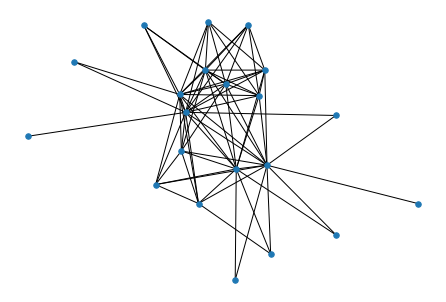

{'LCC': 21,
 'claw_count': 2319.0,
 'cpl': 1.7428571428571429,
 'd': 7.0476190476190474,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.2857142857142856,
 'n_components': 1,
 'node_num': 21,
 'power_law_exp': 1.6081137880822145,
 'rel_edge_distr_entropy': 0.9212679408831612,
 'square_count': 165,
 'triangle_count': 139,
 'wedge_count': 683.0}


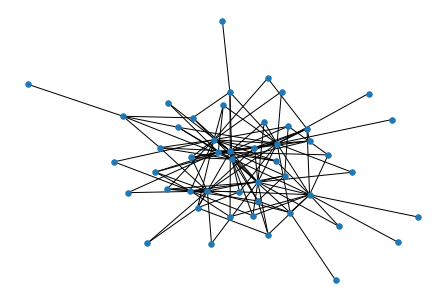

{'LCC': 49,
 'claw_count': 4032.0,
 'cpl': 2.320578231292517,
 'd': 5.346938775510204,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 131,
 'gini': 0.39242872721607736,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7462404139063574,
 'rel_edge_distr_entropy': 0.9187759729123552,
 'square_count': 0,
 'triangle_count': 59,
 'wedge_count': 1089.0}
[1110/2000]: vae_loss:1.7388, prior_loss:0.0002
max tensor(0.8066, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0720, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5239, 0.5272, 0.5190,  ..., 0.5219, 0.5207, 0.5235],
        [0.5272, 0.5455, 0.5285,  ..., 0.5251, 0.5253, 0.5267],
        [0.5190, 0.5285, 0.5634,  ..., 0.5215, 0.5321, 0.5186],
        ...,
        [0.5219, 0.5251, 0.5215,  ..., 0.5209, 0.5209, 0.5216],
        [0.5207, 0.5253, 0.5321,  ..., 0.5209, 0.5242, 0.5204],
        [0.5235, 0.5267, 0.5186,  ..., 0.5216, 0.5204, 0.5232]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


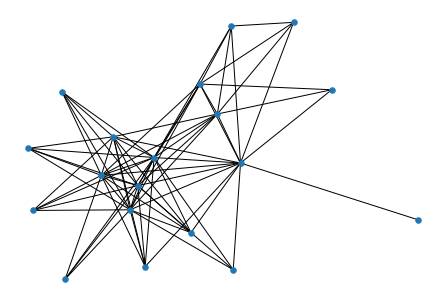

{'LCC': 19,
 'claw_count': 2295.0,
 'cpl': 1.6374269005847952,
 'd': 7.7894736842105265,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.20554765291607402,
 'n_components': 1,
 'node_num': 19,
 'power_law_exp': 1.5372293970640274,
 'rel_edge_distr_entropy': 0.945394277829083,
 'square_count': 142,
 'triangle_count': 137,
 'wedge_count': 683.0}


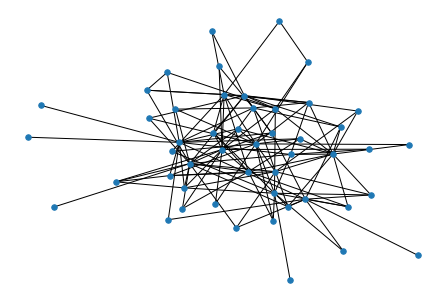

{'LCC': 49,
 'claw_count': 2748.0,
 'cpl': 2.3843537414965987,
 'd': 5.346938775510204,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 131,
 'gini': 0.3534818507555695,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7147709077355118,
 'rel_edge_distr_entropy': 0.9355262184647809,
 'square_count': 3,
 'triangle_count': 37,
 'wedge_count': 947.0}
[1140/2000]: vae_loss:1.6213, prior_loss:0.0002
max tensor(0.7446, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0732, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5228, 0.5228, 0.5264,  ..., 0.5218, 0.5228, 0.5261],
        [0.5228, 0.5228, 0.5264,  ..., 0.5218, 0.5228, 0.5261],
        [0.5264, 0.5264, 0.5712,  ..., 0.5257, 0.5264, 0.5528],
        ...,
        [0.5218, 0.5218, 0.5257,  ..., 0.5213, 0.5218, 0.5250],
        [0.5228, 0.5228, 0.5264,  ..., 0.5218, 0.5228, 0.5261],
        [0.5261, 0.5261, 0.5528,  ..., 0.5250, 0.5261, 0.5427]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


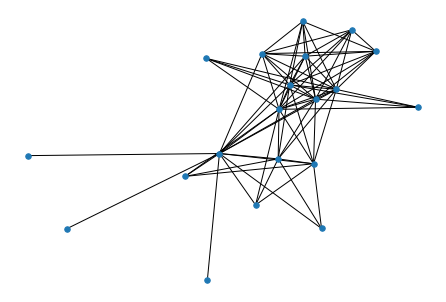

{'LCC': 20,
 'claw_count': 2156.0,
 'cpl': 1.7157894736842105,
 'd': 7.4,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.24054054054054053,
 'n_components': 1,
 'node_num': 20,
 'power_law_exp': 1.580620532924754,
 'rel_edge_distr_entropy': 0.9327005534359641,
 'square_count': 172,
 'triangle_count': 144,
 'wedge_count': 671.0}


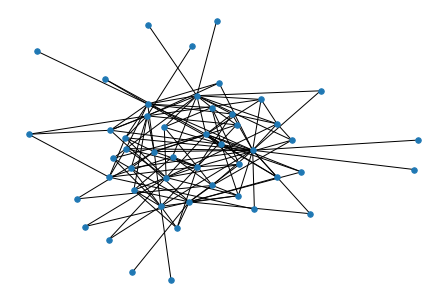

{'LCC': 49,
 'claw_count': 3331.0,
 'cpl': 2.3639455782312924,
 'd': 5.469387755102041,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3641486445324398,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7211169539943845,
 'rel_edge_distr_entropy': 0.9307344714507779,
 'square_count': 3,
 'triangle_count': 56,
 'wedge_count': 1026.0}
[1170/2000]: vae_loss:1.6213, prior_loss:0.0001
max tensor(0.7556, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0684, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5220, 0.5260, 0.5307,  ..., 0.5216, 0.5214, 0.5218],
        [0.5260, 0.5503, 0.5884,  ..., 0.5255, 0.5253, 0.5256],
        [0.5307, 0.5884, 0.6804,  ..., 0.5303, 0.5308, 0.5302],
        ...,
        [0.5216, 0.5255, 0.5303,  ..., 0.5213, 0.5212, 0.5214],
        [0.5214, 0.5253, 0.5308,  ..., 0.5212, 0.5212, 0.5213],
        [0.5218, 0.5256, 0.5302,  ..., 0.5214, 0.5213, 0.5216]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


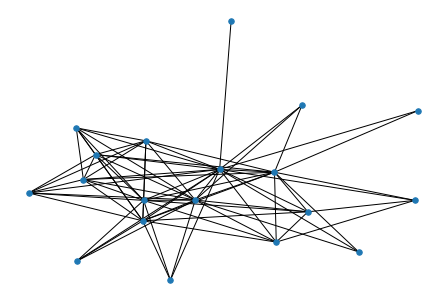

{'LCC': 19,
 'claw_count': 2535.0,
 'cpl': 1.567251461988304,
 'd': 7.7894736842105265,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.22972972972972983,
 'n_components': 1,
 'node_num': 19,
 'power_law_exp': 1.5472690823317303,
 'rel_edge_distr_entropy': 0.9373625223141324,
 'square_count': 184,
 'triangle_count': 148,
 'wedge_count': 709.0}


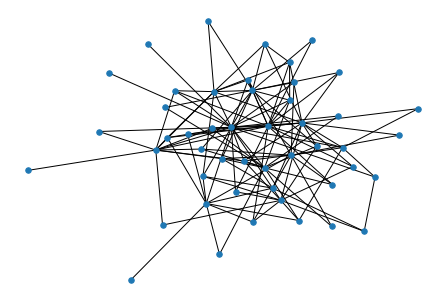

{'LCC': 48,
 'claw_count': 4274.0,
 'cpl': 2.270390070921986,
 'd': 5.458333333333333,
 'd_max': 22.0,
 'd_min': 1.0,
 'edge_num': 131,
 'gini': 0.3859732824427482,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.7232471682734993,
 'rel_edge_distr_entropy': 0.9209555965760314,
 'square_count': 9,
 'triangle_count': 63,
 'wedge_count': 1107.0}
[1200/2000]: vae_loss:1.7153, prior_loss:0.0002
max tensor(0.6135, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0768, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5229, 0.5220, 0.5223,  ..., 0.5220, 0.5206, 0.5222],
        [0.5220, 0.5217, 0.5218,  ..., 0.5216, 0.5210, 0.5218],
        [0.5223, 0.5218, 0.5219,  ..., 0.5217, 0.5209, 0.5219],
        ...,
        [0.5220, 0.5216, 0.5217,  ..., 0.5215, 0.5208, 0.5217],
        [0.5206, 0.5210, 0.5209,  ..., 0.5208, 0.5240, 0.5209],
        [0.5222, 0.5218, 0.5219,  ..., 0.5217, 0.5209, 0.5219]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


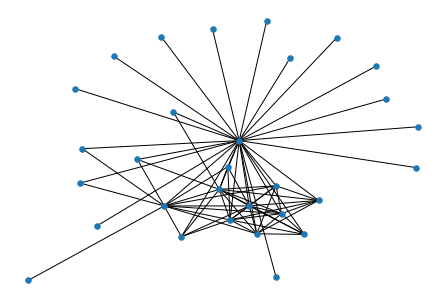

{'LCC': 30,
 'claw_count': 4478.0,
 'cpl': 1.8666666666666667,
 'd': 4.933333333333334,
 'd_max': 28.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.48513513513513495,
 'n_components': 1,
 'node_num': 30,
 'power_law_exp': 2.0044738010672445,
 'rel_edge_distr_entropy': 0.8397950858308436,
 'square_count': 146,
 'triangle_count': 118,
 'wedge_count': 806.0}


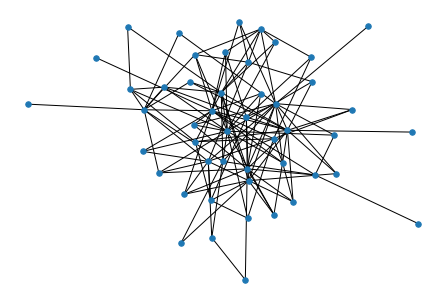

{'LCC': 48,
 'claw_count': 2716.0,
 'cpl': 2.3315602836879434,
 'd': 5.291666666666667,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 127,
 'gini': 0.3385826771653544,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.7089521902459837,
 'rel_edge_distr_entropy': 0.9384801328395387,
 'square_count': 3,
 'triangle_count': 32,
 'wedge_count': 904.0}
[1230/2000]: vae_loss:1.6682, prior_loss:0.0001
max tensor(0.5687, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0761, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5224, 0.5207, 0.5203,  ..., 0.5217, 0.5224, 0.5224],
        [0.5207, 0.5229, 0.5238,  ..., 0.5208, 0.5207, 0.5207],
        [0.5203, 0.5238, 0.5251,  ..., 0.5207, 0.5203, 0.5203],
        ...,
        [0.5217, 0.5208, 0.5207,  ..., 0.5213, 0.5217, 0.5217],
        [0.5224, 0.5207, 0.5203,  ..., 0.5217, 0.5224, 0.5224],
        [0.5224, 0.5207, 0.5203,  ..., 0.5217, 0.5224, 0.5224]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


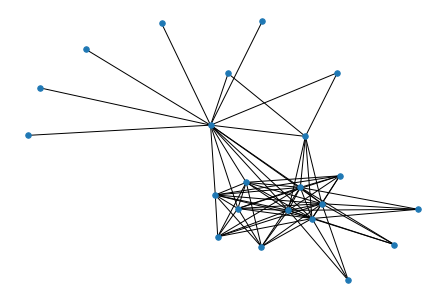

{'LCC': 22,
 'claw_count': 2342.0,
 'cpl': 1.8614718614718615,
 'd': 6.7272727272727275,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.3224815724815726,
 'n_components': 1,
 'node_num': 22,
 'power_law_exp': 1.663869106266876,
 'rel_edge_distr_entropy': 0.9050954598067118,
 'square_count': 194,
 'triangle_count': 146,
 'wedge_count': 692.0}


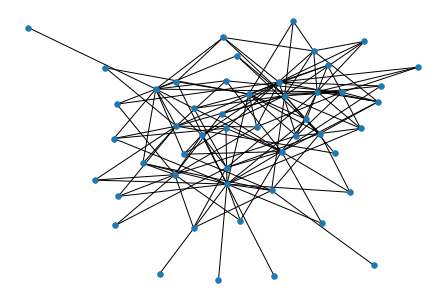

{'LCC': 50,
 'claw_count': 3086.0,
 'cpl': 2.3142857142857145,
 'd': 5.56,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 139,
 'gini': 0.33107913669064737,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.6813635326628524,
 'rel_edge_distr_entropy': 0.9426395284557012,
 'square_count': 0,
 'triangle_count': 31,
 'wedge_count': 1014.0}
[1260/2000]: vae_loss:1.6213, prior_loss:0.0001
max tensor(0.4714, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0760, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5226, 0.5211, 0.5258,  ..., 0.5226, 0.5226, 0.5260],
        [0.5211, 0.5217, 0.5255,  ..., 0.5211, 0.5211, 0.5244],
        [0.5258, 0.5255, 0.5594,  ..., 0.5258, 0.5258, 0.5501],
        ...,
        [0.5226, 0.5211, 0.5258,  ..., 0.5225, 0.5226, 0.5259],
        [0.5226, 0.5211, 0.5258,  ..., 0.5226, 0.5226, 0.5260],
        [0.5260, 0.5244, 0.5501,  ..., 0.5259, 0.5260, 0.5441]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


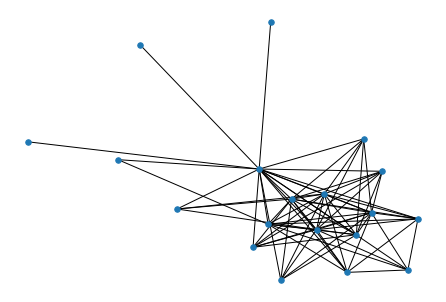

{'LCC': 19,
 'claw_count': 2524.0,
 'cpl': 1.567251461988304,
 'd': 7.7894736842105265,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.23968705547652913,
 'n_components': 1,
 'node_num': 19,
 'power_law_exp': 1.569973712640496,
 'rel_edge_distr_entropy': 0.9289851813124851,
 'square_count': 209,
 'triangle_count': 159,
 'wedge_count': 718.0}


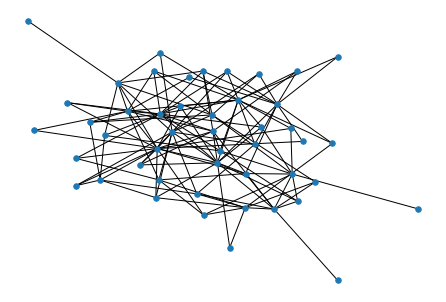

{'LCC': 47,
 'claw_count': 2967.0,
 'cpl': 2.2932469935245146,
 'd': 5.617021276595745,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 132,
 'gini': 0.32398452611218587,
 'n_components': 1,
 'node_num': 47,
 'power_law_exp': 1.6699674172908932,
 'rel_edge_distr_entropy': 0.9430192934703443,
 'square_count': 6,
 'triangle_count': 55,
 'wedge_count': 971.0}
[1290/2000]: vae_loss:1.6213, prior_loss:0.0001
max tensor(0.5003, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0793, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5223, 0.5260, 0.5291,  ..., 0.5220, 0.5207, 0.5253],
        [0.5260, 0.5472, 0.5716,  ..., 0.5256, 0.5252, 0.5420],
        [0.5291, 0.5716, 0.6225,  ..., 0.5287, 0.5315, 0.5605],
        ...,
        [0.5220, 0.5256, 0.5287,  ..., 0.5218, 0.5208, 0.5250],
        [0.5207, 0.5252, 0.5315,  ..., 0.5208, 0.5232, 0.5239],
        [0.5253, 0.5420, 0.5605,  ..., 0.5250, 0.5239, 0.5380]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


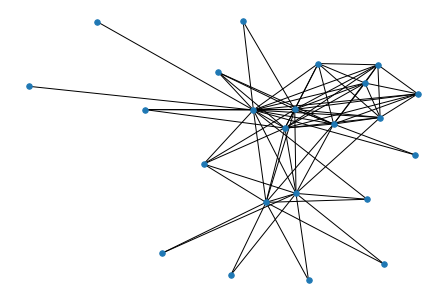

{'LCC': 23,
 'claw_count': 2389.0,
 'cpl': 1.865612648221344,
 'd': 6.434782608695652,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.32902467685076386,
 'n_components': 1,
 'node_num': 23,
 'power_law_exp': 1.6563208358313002,
 'rel_edge_distr_entropy': 0.9098744940992002,
 'square_count': 141,
 'triangle_count': 125,
 'wedge_count': 674.0}


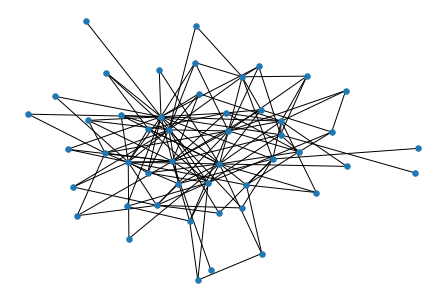

{'LCC': 49,
 'claw_count': 3833.0,
 'cpl': 2.2823129251700682,
 'd': 5.510204081632653,
 'd_max': 21.0,
 'd_min': 1.0,
 'edge_num': 135,
 'gini': 0.35404383975812537,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.695444621083239,
 'rel_edge_distr_entropy': 0.9331688374361047,
 'square_count': 3,
 'triangle_count': 54,
 'wedge_count': 1067.0}
[1320/2000]: vae_loss:1.6447, prior_loss:0.0001
max tensor(0.4731, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0788, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5224, 0.5207, 0.5285,  ..., 0.5222, 0.5216, 0.5219],
        [0.5207, 0.5234, 0.5306,  ..., 0.5207, 0.5211, 0.5208],
        [0.5285, 0.5306, 0.6161,  ..., 0.5284, 0.5280, 0.5278],
        ...,
        [0.5222, 0.5207, 0.5284,  ..., 0.5221, 0.5215, 0.5218],
        [0.5216, 0.5211, 0.5280,  ..., 0.5215, 0.5213, 0.5214],
        [0.5219, 0.5208, 0.5278,  ..., 0.5218, 0.5214, 0.5216]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


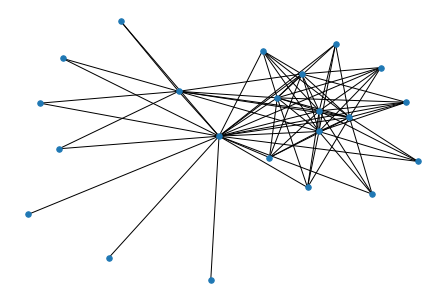

{'LCC': 22,
 'claw_count': 2990.0,
 'cpl': 1.6796536796536796,
 'd': 6.7272727272727275,
 'd_max': 21.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.33476658476658483,
 'n_components': 1,
 'node_num': 22,
 'power_law_exp': 1.647385135939257,
 'rel_edge_distr_entropy': 0.9032357280122406,
 'square_count': 143,
 'triangle_count': 131,
 'wedge_count': 735.0}


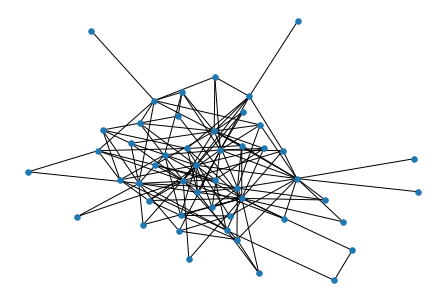

{'LCC': 49,
 'claw_count': 3113.0,
 'cpl': 2.3154761904761907,
 'd': 5.63265306122449,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 138,
 'gini': 0.3172138420585626,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.668736464620014,
 'rel_edge_distr_entropy': 0.9453578225454831,
 'square_count': 0,
 'triangle_count': 30,
 'wedge_count': 1006.0}
[1350/2000]: vae_loss:1.6682, prior_loss:0.0001
max tensor(0.3498, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0761, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5221, 0.5250, 0.5196,  ..., 0.5222, 0.5217, 0.5248],
        [0.5250, 0.5376, 0.5260,  ..., 0.5252, 0.5244, 0.5362],
        [0.5196, 0.5260, 0.5540,  ..., 0.5192, 0.5201, 0.5247],
        ...,
        [0.5222, 0.5252, 0.5192,  ..., 0.5224, 0.5217, 0.5250],
        [0.5217, 0.5244, 0.5201,  ..., 0.5217, 0.5214, 0.5242],
        [0.5248, 0.5362, 0.5247,  ..., 0.5250, 0.5242, 0.5349]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


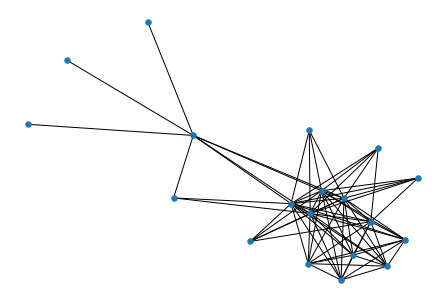

{'LCC': 19,
 'claw_count': 2369.0,
 'cpl': 1.7426900584795322,
 'd': 7.7894736842105265,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.2304409672830725,
 'n_components': 1,
 'node_num': 19,
 'power_law_exp': 1.5661854974444687,
 'rel_edge_distr_entropy': 0.9319866196292451,
 'square_count': 249,
 'triangle_count': 165,
 'wedge_count': 705.0}


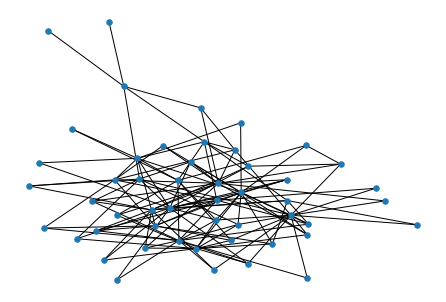

{'LCC': 50,
 'claw_count': 2713.0,
 'cpl': 2.3591836734693876,
 'd': 5.4,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 135,
 'gini': 0.32044444444444453,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.6816161216393257,
 'rel_edge_distr_entropy': 0.9457505325597442,
 'square_count': 1,
 'triangle_count': 34,
 'wedge_count': 941.0}
[1380/2000]: vae_loss:1.6682, prior_loss:0.0000
max tensor(0.2793, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0765, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5221, 0.5242, 0.5196,  ..., 0.5219, 0.5214, 0.5243],
        [0.5242, 0.5305, 0.5217,  ..., 0.5240, 0.5234, 0.5307],
        [0.5196, 0.5217, 0.5314,  ..., 0.5197, 0.5211, 0.5218],
        ...,
        [0.5219, 0.5240, 0.5197,  ..., 0.5217, 0.5213, 0.5240],
        [0.5214, 0.5234, 0.5211,  ..., 0.5213, 0.5212, 0.5234],
        [0.5243, 0.5307, 0.5218,  ..., 0.5240, 0.5234, 0.5309]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


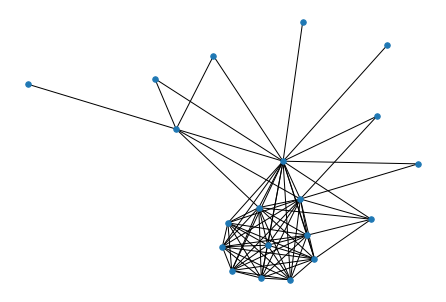

{'LCC': 20,
 'claw_count': 2480.0,
 'cpl': 1.6789473684210525,
 'd': 7.4,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.2682432432432431,
 'n_components': 1,
 'node_num': 20,
 'power_law_exp': 1.6097668252786663,
 'rel_edge_distr_entropy': 0.9146825497696943,
 'square_count': 341,
 'triangle_count': 182,
 'wedge_count': 719.0}


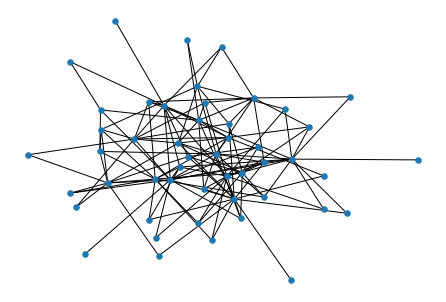

{'LCC': 49,
 'claw_count': 2767.0,
 'cpl': 2.3435374149659864,
 'd': 5.469387755102041,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.34785257386536705,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6999028907902525,
 'rel_edge_distr_entropy': 0.9378085387866496,
 'square_count': 2,
 'triangle_count': 42,
 'wedge_count': 972.0}
[1410/2000]: vae_loss:1.6917, prior_loss:0.0000
max tensor(0.2484, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0799, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5221, 0.5215, 0.5260,  ..., 0.5222, 0.5230, 0.5223],
        [0.5215, 0.5214, 0.5256,  ..., 0.5215, 0.5221, 0.5215],
        [0.5260, 0.5256, 0.5618,  ..., 0.5262, 0.5275, 0.5263],
        ...,
        [0.5222, 0.5215, 0.5262,  ..., 0.5223, 0.5231, 0.5224],
        [0.5230, 0.5221, 0.5275,  ..., 0.5231, 0.5241, 0.5233],
        [0.5223, 0.5215, 0.5263,  ..., 0.5224, 0.5233, 0.5226]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


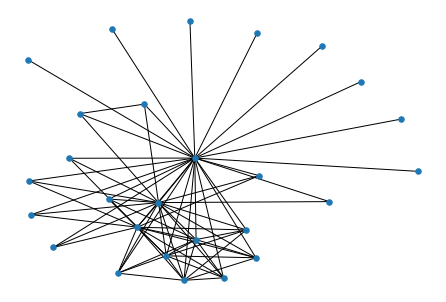

{'LCC': 27,
 'claw_count': 4292.0,
 'cpl': 1.789173789173789,
 'd': 5.481481481481482,
 'd_max': 26.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.4369369369369369,
 'n_components': 1,
 'node_num': 27,
 'power_law_exp': 1.8226986268295229,
 'rel_edge_distr_entropy': 0.8628687979425598,
 'square_count': 111,
 'triangle_count': 110,
 'wedge_count': 801.0}


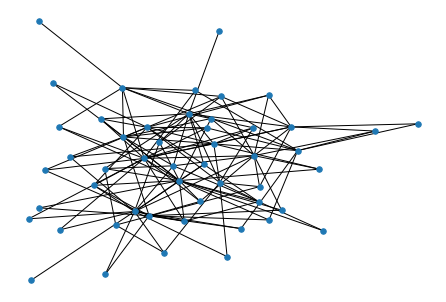

{'LCC': 50,
 'claw_count': 3181.0,
 'cpl': 2.346122448979592,
 'd': 5.36,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3441791044776119,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.6999566051953507,
 'rel_edge_distr_entropy': 0.9377461284575428,
 'square_count': 1,
 'triangle_count': 37,
 'wedge_count': 989.0}
[1440/2000]: vae_loss:1.6447, prior_loss:0.0000
max tensor(0.1787, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0762, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5225, 0.5221, 0.5192,  ..., 0.5225, 0.5232, 0.5247],
        [0.5221, 0.5218, 0.5197,  ..., 0.5221, 0.5227, 0.5241],
        [0.5192, 0.5197, 0.5334,  ..., 0.5193, 0.5195, 0.5223],
        ...,
        [0.5225, 0.5221, 0.5193,  ..., 0.5225, 0.5232, 0.5247],
        [0.5232, 0.5227, 0.5195,  ..., 0.5232, 0.5240, 0.5257],
        [0.5247, 0.5241, 0.5223,  ..., 0.5247, 0.5257, 0.5318]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


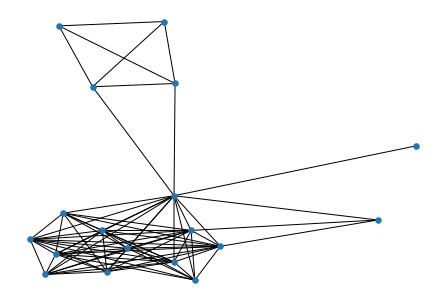

{'LCC': 18,
 'claw_count': 2075.0,
 'cpl': 1.6862745098039216,
 'd': 8.222222222222221,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.1561561561561562,
 'n_components': 1,
 'node_num': 18,
 'power_law_exp': 1.5215540733401824,
 'rel_edge_distr_entropy': 0.9520274760713298,
 'square_count': 352,
 'triangle_count': 192,
 'wedge_count': 678.0}


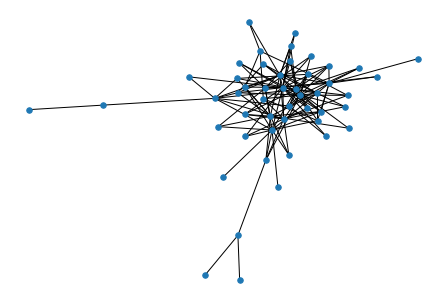

{'LCC': 49,
 'claw_count': 4162.0,
 'cpl': 2.442176870748299,
 'd': 5.387755102040816,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 132,
 'gini': 0.3849721706864564,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7318744294650303,
 'rel_edge_distr_entropy': 0.9214811254043935,
 'square_count': 3,
 'triangle_count': 58,
 'wedge_count': 1099.0}
[1470/2000]: vae_loss:1.7152, prior_loss:0.0000
max tensor(0.2744, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0765, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5224, 0.5222, 0.5211,  ..., 0.5225, 0.5226, 0.5247],
        [0.5222, 0.5221, 0.5211,  ..., 0.5223, 0.5224, 0.5245],
        [0.5211, 0.5211, 0.5218,  ..., 0.5211, 0.5211, 0.5231],
        ...,
        [0.5225, 0.5223, 0.5211,  ..., 0.5226, 0.5227, 0.5248],
        [0.5226, 0.5224, 0.5211,  ..., 0.5227, 0.5228, 0.5250],
        [0.5247, 0.5245, 0.5231,  ..., 0.5248, 0.5250, 0.5322]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


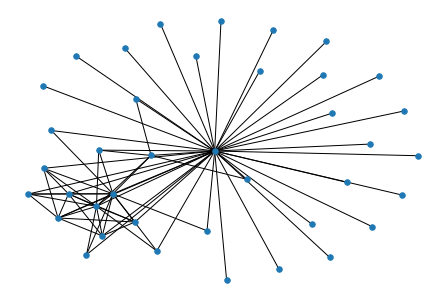

{'LCC': 39,
 'claw_count': 9218.0,
 'cpl': 1.9001349527665317,
 'd': 3.7948717948717947,
 'd_max': 38.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.5360360360360361,
 'n_components': 1,
 'node_num': 39,
 'power_law_exp': 2.399319243314391,
 'rel_edge_distr_entropy': 0.8028120589718676,
 'square_count': 62,
 'triangle_count': 74,
 'wedge_count': 997.0}


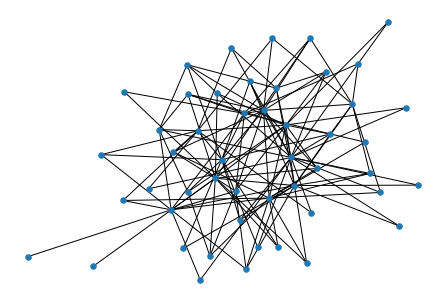

{'LCC': 49,
 'claw_count': 3294.0,
 'cpl': 2.2670068027210886,
 'd': 5.346938775510204,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 131,
 'gini': 0.3547281508023057,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7072088597982182,
 'rel_edge_distr_entropy': 0.9328775358977923,
 'square_count': 0,
 'triangle_count': 33,
 'wedge_count': 997.0}
[1500/2000]: vae_loss:1.6682, prior_loss:0.0000
max tensor(0.2322, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0739, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5220, 0.5236, 0.5214,  ..., 0.5223, 0.5223, 0.5219],
        [0.5236, 0.5266, 0.5227,  ..., 0.5240, 0.5240, 0.5235],
        [0.5214, 0.5227, 0.5214,  ..., 0.5215, 0.5215, 0.5214],
        ...,
        [0.5223, 0.5240, 0.5215,  ..., 0.5226, 0.5226, 0.5221],
        [0.5223, 0.5240, 0.5215,  ..., 0.5226, 0.5226, 0.5221],
        [0.5219, 0.5235, 0.5214,  ..., 0.5221, 0.5221, 0.5218]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


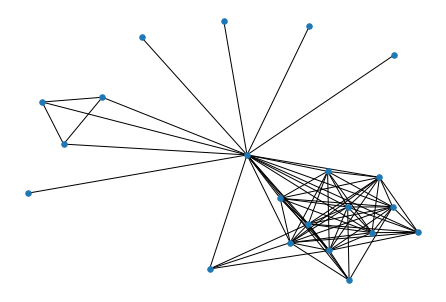

{'LCC': 21,
 'claw_count': 2621.0,
 'cpl': 1.6476190476190475,
 'd': 7.0476190476190474,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.301158301158301,
 'n_components': 1,
 'node_num': 21,
 'power_law_exp': 1.6402596288706706,
 'rel_edge_distr_entropy': 0.9077885235611278,
 'square_count': 291,
 'triangle_count': 173,
 'wedge_count': 718.0}


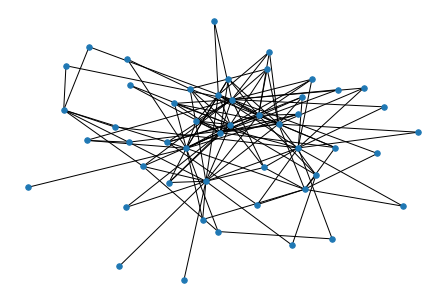

{'LCC': 49,
 'claw_count': 4442.0,
 'cpl': 2.2891156462585034,
 'd': 5.469387755102041,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3906487968321657,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.724322879780053,
 'rel_edge_distr_entropy': 0.9187557151852419,
 'square_count': 8,
 'triangle_count': 65,
 'wedge_count': 1155.0}
[1530/2000]: vae_loss:1.6682, prior_loss:0.0000
max tensor(0.1811, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0807, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5226, 0.5243, 0.5207,  ..., 0.5226, 0.5226, 0.5240],
        [0.5243, 0.5288, 0.5223,  ..., 0.5243, 0.5243, 0.5274],
        [0.5207, 0.5223, 0.5220,  ..., 0.5207, 0.5207, 0.5219],
        ...,
        [0.5226, 0.5243, 0.5207,  ..., 0.5226, 0.5226, 0.5240],
        [0.5226, 0.5243, 0.5207,  ..., 0.5226, 0.5226, 0.5240],
        [0.5240, 0.5274, 0.5219,  ..., 0.5240, 0.5240, 0.5265]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


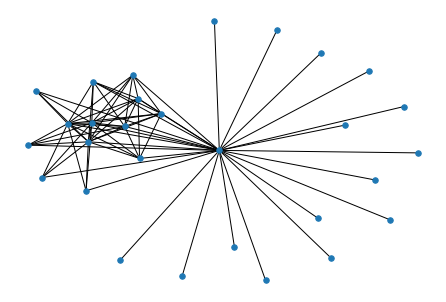

{'LCC': 29,
 'claw_count': 4549.0,
 'cpl': 1.8177339901477831,
 'd': 5.103448275862069,
 'd_max': 28.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.47996272134203166,
 'n_components': 1,
 'node_num': 29,
 'power_law_exp': 1.9887440601162174,
 'rel_edge_distr_entropy': 0.8390063793814841,
 'square_count': 162,
 'triangle_count': 126,
 'wedge_count': 820.0}


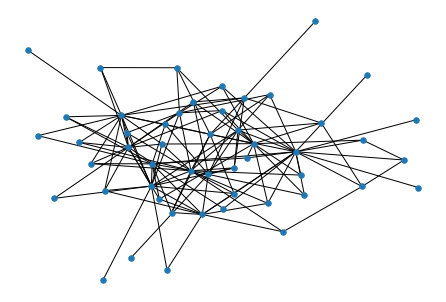

{'LCC': 50,
 'claw_count': 3926.0,
 'cpl': 2.3453061224489797,
 'd': 5.4,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 135,
 'gini': 0.37496296296296294,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7265241351977587,
 'rel_edge_distr_entropy': 0.9253302962702942,
 'square_count': 7,
 'triangle_count': 55,
 'wedge_count': 1092.0}
[1560/2000]: vae_loss:1.6212, prior_loss:0.0000
max tensor(0.1625, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0738, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5227, 0.5242, 0.5225,  ..., 0.5227, 0.5224, 0.5244],
        [0.5242, 0.5273, 0.5240,  ..., 0.5242, 0.5239, 0.5279],
        [0.5225, 0.5240, 0.5223,  ..., 0.5225, 0.5223, 0.5242],
        ...,
        [0.5227, 0.5242, 0.5225,  ..., 0.5227, 0.5224, 0.5244],
        [0.5224, 0.5239, 0.5223,  ..., 0.5224, 0.5222, 0.5241],
        [0.5244, 0.5279, 0.5242,  ..., 0.5244, 0.5241, 0.5288]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


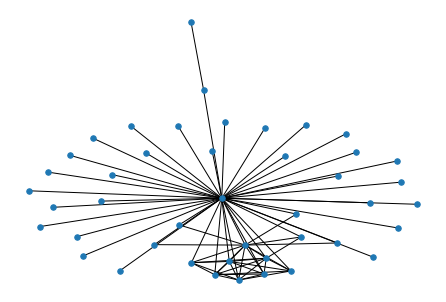

{'LCC': 44,
 'claw_count': 12079.0,
 'cpl': 1.9651162790697674,
 'd': 3.3636363636363638,
 'd_max': 42.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.5506756756756757,
 'n_components': 1,
 'node_num': 44,
 'power_law_exp': 2.782979411131275,
 'rel_edge_distr_entropy': 0.7804447780307971,
 'square_count': 76,
 'triangle_count': 72,
 'wedge_count': 1112.0}


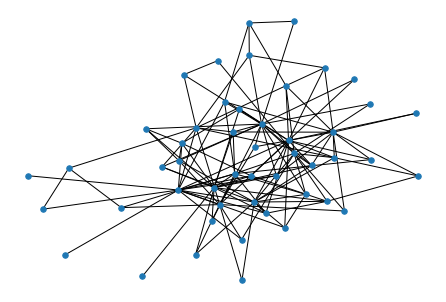

{'LCC': 49,
 'claw_count': 3140.0,
 'cpl': 2.332482993197279,
 'd': 5.428571428571429,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 133,
 'gini': 0.342028540739604,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6942377929630956,
 'rel_edge_distr_entropy': 0.9376152280391663,
 'square_count': 2,
 'triangle_count': 40,
 'wedge_count': 990.0}
[1590/2000]: vae_loss:1.6447, prior_loss:0.0000
max tensor(0.1541, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0823, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5221, 0.5220, 0.5221,  ..., 0.5223, 0.5223, 0.5223],
        [0.5220, 0.5219, 0.5220,  ..., 0.5221, 0.5222, 0.5222],
        [0.5221, 0.5220, 0.5220,  ..., 0.5222, 0.5222, 0.5222],
        ...,
        [0.5223, 0.5221, 0.5222,  ..., 0.5224, 0.5224, 0.5224],
        [0.5223, 0.5222, 0.5222,  ..., 0.5224, 0.5225, 0.5225],
        [0.5223, 0.5222, 0.5222,  ..., 0.5224, 0.5225, 0.5225]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


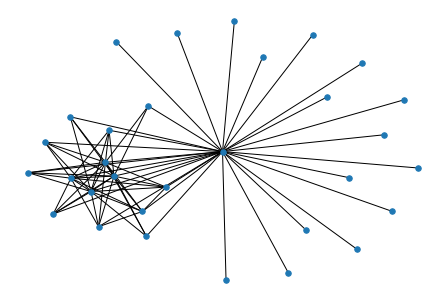

{'LCC': 31,
 'claw_count': 5363.0,
 'cpl': 1.8408602150537634,
 'd': 4.774193548387097,
 'd_max': 30.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.4978204010462075,
 'n_components': 1,
 'node_num': 31,
 'power_law_exp': 2.051541174692269,
 'rel_edge_distr_entropy': 0.8307972322000584,
 'square_count': 104,
 'triangle_count': 105,
 'wedge_count': 856.0}


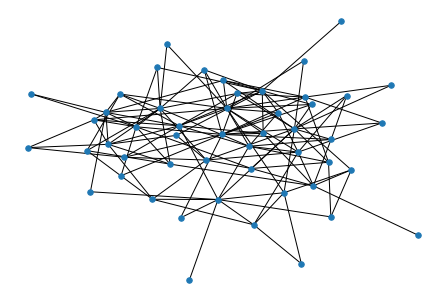

{'LCC': 50,
 'claw_count': 2245.0,
 'cpl': 2.431020408163265,
 'd': 5.44,
 'd_max': 14.0,
 'd_min': 1.0,
 'edge_num': 136,
 'gini': 0.299264705882353,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.6724516486073555,
 'rel_edge_distr_entropy': 0.9527816996364179,
 'square_count': 2,
 'triangle_count': 40,
 'wedge_count': 889.0}
[1620/2000]: vae_loss:1.6682, prior_loss:0.0000
max tensor(0.1812, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0751, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5223, 0.5240, 0.5255,  ..., 0.5222, 0.5223, 0.5234],
        [0.5240, 0.5274, 0.5324,  ..., 0.5239, 0.5240, 0.5255],
        [0.5255, 0.5324, 0.5452,  ..., 0.5254, 0.5255, 0.5276],
        ...,
        [0.5222, 0.5239, 0.5254,  ..., 0.5222, 0.5222, 0.5233],
        [0.5223, 0.5240, 0.5255,  ..., 0.5222, 0.5223, 0.5234],
        [0.5234, 0.5255, 0.5276,  ..., 0.5233, 0.5234, 0.5247]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


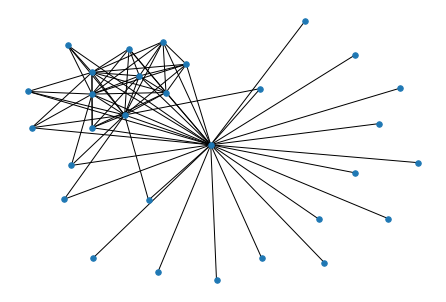

{'LCC': 30,
 'claw_count': 5011.0,
 'cpl': 1.8298850574712644,
 'd': 4.933333333333334,
 'd_max': 29.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.4891891891891891,
 'n_components': 1,
 'node_num': 30,
 'power_law_exp': 1.9869568433978166,
 'rel_edge_distr_entropy': 0.8383852817929573,
 'square_count': 123,
 'triangle_count': 110,
 'wedge_count': 838.0}


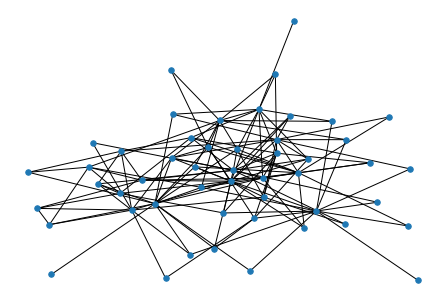

{'LCC': 50,
 'claw_count': 2716.0,
 'cpl': 2.3714285714285714,
 'd': 5.44,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 136,
 'gini': 0.32985294117647057,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.6877831579101112,
 'rel_edge_distr_entropy': 0.9435198047290002,
 'square_count': 0,
 'triangle_count': 33,
 'wedge_count': 957.0}
[1650/2000]: vae_loss:1.7387, prior_loss:0.0000
max tensor(0.1414, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0826, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5224, 0.5225, 0.5225,  ..., 0.5225, 0.5224, 0.5225],
        [0.5225, 0.5227, 0.5227,  ..., 0.5227, 0.5225, 0.5227],
        [0.5225, 0.5227, 0.5227,  ..., 0.5227, 0.5225, 0.5227],
        ...,
        [0.5225, 0.5227, 0.5227,  ..., 0.5227, 0.5225, 0.5227],
        [0.5224, 0.5225, 0.5225,  ..., 0.5225, 0.5223, 0.5225],
        [0.5225, 0.5227, 0.5227,  ..., 0.5227, 0.5225, 0.5227]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


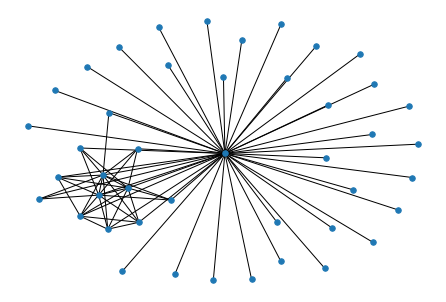

{'LCC': 44,
 'claw_count': 12944.0,
 'cpl': 1.9217758985200846,
 'd': 3.3636363636363638,
 'd_max': 43.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.5552825552825553,
 'n_components': 1,
 'node_num': 44,
 'power_law_exp': 2.8305800887230648,
 'rel_edge_distr_entropy': 0.7751713105083462,
 'square_count': 58,
 'triangle_count': 67,
 'wedge_count': 1152.0}


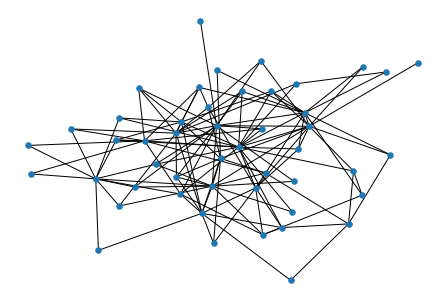

{'LCC': 48,
 'claw_count': 2907.0,
 'cpl': 2.327127659574468,
 'd': 5.416666666666667,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 130,
 'gini': 0.33750000000000013,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.6914063592674586,
 'rel_edge_distr_entropy': 0.9389960113568213,
 'square_count': 4,
 'triangle_count': 51,
 'wedge_count': 950.0}
[1680/2000]: vae_loss:1.4098, prior_loss:0.0000
max tensor(0.1345, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0833, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5227, 0.5225, 0.5210,  ..., 0.5227, 0.5225, 0.5240],
        [0.5225, 0.5223, 0.5210,  ..., 0.5224, 0.5223, 0.5237],
        [0.5210, 0.5210, 0.5216,  ..., 0.5210, 0.5210, 0.5222],
        ...,
        [0.5227, 0.5224, 0.5210,  ..., 0.5226, 0.5225, 0.5239],
        [0.5225, 0.5223, 0.5210,  ..., 0.5225, 0.5224, 0.5238],
        [0.5240, 0.5237, 0.5222,  ..., 0.5239, 0.5238, 0.5260]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


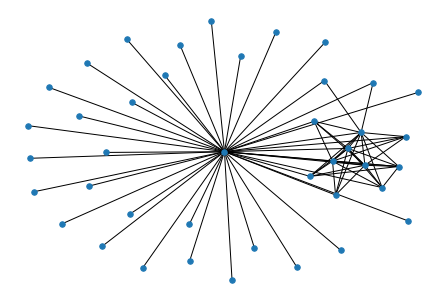

{'LCC': 41,
 'claw_count': 10565.0,
 'cpl': 1.9097560975609755,
 'd': 3.6097560975609757,
 'd_max': 40.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.5517468688200395,
 'n_components': 1,
 'node_num': 41,
 'power_law_exp': 2.6515224362786167,
 'rel_edge_distr_entropy': 0.7843672973216999,
 'square_count': 85,
 'triangle_count': 82,
 'wedge_count': 1064.0}


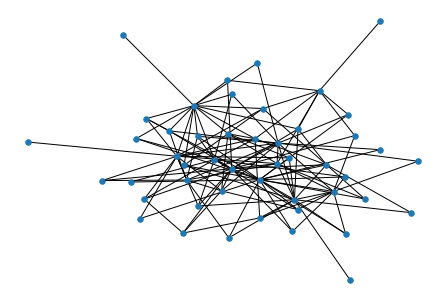

{'LCC': 48,
 'claw_count': 3741.0,
 'cpl': 2.25531914893617,
 'd': 5.583333333333333,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3599191542288558,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.6944594512514244,
 'rel_edge_distr_entropy': 0.9310349478065222,
 'square_count': 4,
 'triangle_count': 51,
 'wedge_count': 1074.0}
[1710/2000]: vae_loss:1.6917, prior_loss:0.0000
max tensor(0.1148, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0831, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5225, 0.5225, 0.5210,  ..., 0.5226, 0.5225, 0.5226],
        [0.5225, 0.5224, 0.5210,  ..., 0.5226, 0.5225, 0.5226],
        [0.5210, 0.5210, 0.5217,  ..., 0.5210, 0.5210, 0.5210],
        ...,
        [0.5226, 0.5226, 0.5210,  ..., 0.5227, 0.5226, 0.5227],
        [0.5225, 0.5225, 0.5210,  ..., 0.5226, 0.5226, 0.5226],
        [0.5226, 0.5226, 0.5210,  ..., 0.5227, 0.5226, 0.5227]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


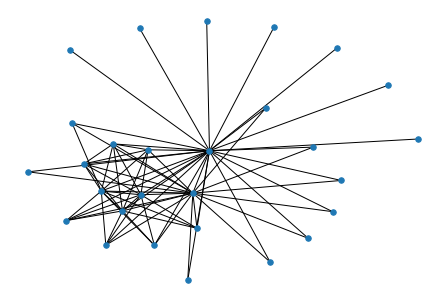

{'LCC': 28,
 'claw_count': 4761.0,
 'cpl': 1.8042328042328042,
 'd': 5.285714285714286,
 'd_max': 27.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.4560810810810809,
 'n_components': 1,
 'node_num': 28,
 'power_law_exp': 1.8617628336896548,
 'rel_edge_distr_entropy': 0.852999818748905,
 'square_count': 111,
 'triangle_count': 107,
 'wedge_count': 831.0}


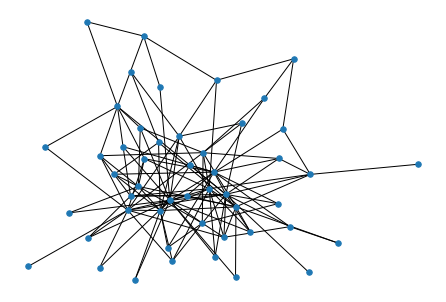

{'LCC': 49,
 'claw_count': 2961.0,
 'cpl': 2.370748299319728,
 'd': 5.224489795918367,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 128,
 'gini': 0.34470663265306123,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7132856910192635,
 'rel_edge_distr_entropy': 0.9365753936923382,
 'square_count': 2,
 'triangle_count': 40,
 'wedge_count': 927.0}
[1740/2000]: vae_loss:1.6682, prior_loss:0.0000
max tensor(0.1361, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0830, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5224, 0.5237, 0.5210,  ..., 0.5226, 0.5226, 0.5237],
        [0.5237, 0.5255, 0.5221,  ..., 0.5239, 0.5239, 0.5254],
        [0.5210, 0.5221, 0.5216,  ..., 0.5210, 0.5210, 0.5220],
        ...,
        [0.5226, 0.5239, 0.5210,  ..., 0.5228, 0.5228, 0.5238],
        [0.5226, 0.5239, 0.5210,  ..., 0.5228, 0.5228, 0.5238],
        [0.5237, 0.5254, 0.5220,  ..., 0.5238, 0.5238, 0.5253]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


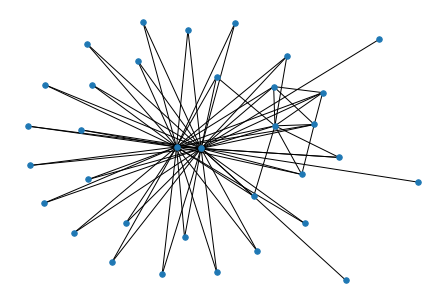

{'LCC': 34,
 'claw_count': 9684.0,
 'cpl': 1.8680926916221035,
 'd': 4.352941176470588,
 'd_max': 33.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.45270270270270285,
 'n_components': 1,
 'node_num': 34,
 'power_law_exp': 2.0042944677914596,
 'rel_edge_distr_entropy': 0.8159360775336091,
 'square_count': 23,
 'triangle_count': 58,
 'wedge_count': 1081.0}


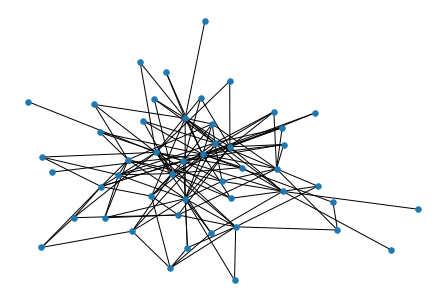

{'LCC': 49,
 'claw_count': 2811.0,
 'cpl': 2.3477891156462585,
 'd': 5.469387755102041,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3426743831861103,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.69694454091118,
 'rel_edge_distr_entropy': 0.9392077247403375,
 'square_count': 1,
 'triangle_count': 38,
 'wedge_count': 969.0}
[1770/2000]: vae_loss:1.6917, prior_loss:0.0000
max tensor(0.1244, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0841, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5227, 0.5238, 0.5217,  ..., 0.5227, 0.5223, 0.5227],
        [0.5238, 0.5252, 0.5228,  ..., 0.5238, 0.5233, 0.5238],
        [0.5217, 0.5228, 0.5213,  ..., 0.5217, 0.5216, 0.5217],
        ...,
        [0.5227, 0.5238, 0.5217,  ..., 0.5227, 0.5223, 0.5227],
        [0.5223, 0.5233, 0.5216,  ..., 0.5223, 0.5220, 0.5223],
        [0.5227, 0.5238, 0.5217,  ..., 0.5227, 0.5223, 0.5227]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


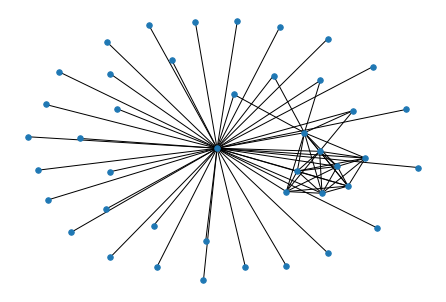

{'LCC': 43,
 'claw_count': 12079.0,
 'cpl': 1.9180509413067552,
 'd': 3.441860465116279,
 'd_max': 42.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.554054054054054,
 'n_components': 1,
 'node_num': 43,
 'power_law_exp': 2.8061579884238865,
 'rel_edge_distr_entropy': 0.7756428495163449,
 'square_count': 106,
 'triangle_count': 83,
 'wedge_count': 1123.0}


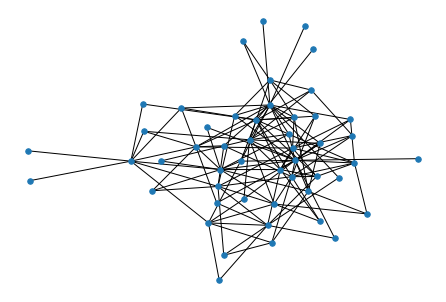

{'LCC': 50,
 'claw_count': 2681.0,
 'cpl': 2.396734693877551,
 'd': 5.32,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 133,
 'gini': 0.34390977443609017,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7130036611184374,
 'rel_edge_distr_entropy': 0.9392858606692207,
 'square_count': 2,
 'triangle_count': 45,
 'wedge_count': 934.0}
[1800/2000]: vae_loss:1.5272, prior_loss:0.0000
max tensor(0.1293, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0845, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5225, 0.5234, 0.5246,  ..., 0.5225, 0.5228, 0.5232],
        [0.5234, 0.5244, 0.5258,  ..., 0.5234, 0.5237, 0.5242],
        [0.5246, 0.5258, 0.5323,  ..., 0.5246, 0.5250, 0.5255],
        ...,
        [0.5225, 0.5234, 0.5246,  ..., 0.5225, 0.5228, 0.5232],
        [0.5228, 0.5237, 0.5250,  ..., 0.5228, 0.5231, 0.5235],
        [0.5232, 0.5242, 0.5255,  ..., 0.5232, 0.5235, 0.5239]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


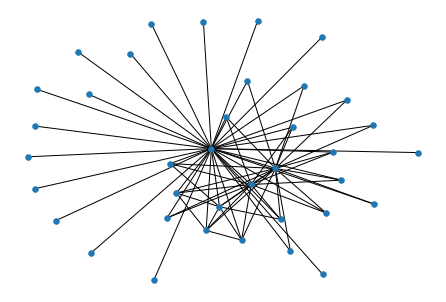

{'LCC': 37,
 'claw_count': 8754.0,
 'cpl': 1.8888888888888888,
 'd': 4.0,
 'd_max': 36.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.5230094959824689,
 'n_components': 1,
 'node_num': 37,
 'power_law_exp': 2.240298397873495,
 'rel_edge_distr_entropy': 0.8065853124859418,
 'square_count': 39,
 'triangle_count': 66,
 'wedge_count': 1010.0}


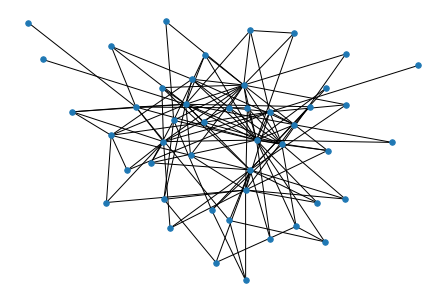

{'LCC': 47,
 'claw_count': 4485.0,
 'cpl': 2.215541165587419,
 'd': 5.617021276595745,
 'd_max': 21.0,
 'd_min': 1.0,
 'edge_num': 132,
 'gini': 0.35815602836879434,
 'n_components': 1,
 'node_num': 47,
 'power_law_exp': 1.6881999821629654,
 'rel_edge_distr_entropy': 0.9278460392771022,
 'square_count': 13,
 'triangle_count': 74,
 'wedge_count': 1121.0}
[1830/2000]: vae_loss:1.6682, prior_loss:0.0000
max tensor(0.1131, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0853, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5226, 0.5226, 0.5225,  ..., 0.5226, 0.5223, 0.5233],
        [0.5226, 0.5226, 0.5225,  ..., 0.5226, 0.5223, 0.5233],
        [0.5225, 0.5225, 0.5223,  ..., 0.5225, 0.5221, 0.5231],
        ...,
        [0.5226, 0.5226, 0.5225,  ..., 0.5226, 0.5223, 0.5233],
        [0.5223, 0.5223, 0.5221,  ..., 0.5223, 0.5220, 0.5229],
        [0.5233, 0.5233, 0.5231,  ..., 0.5233, 0.5229, 0.5240]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


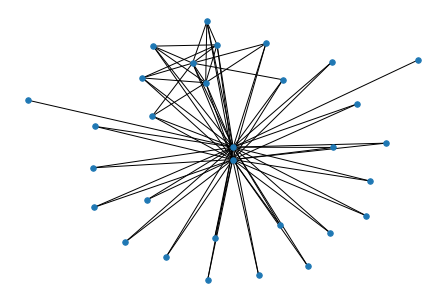

{'LCC': 31,
 'claw_count': 7614.0,
 'cpl': 1.8408602150537634,
 'd': 4.774193548387097,
 'd_max': 30.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.4446381865736704,
 'n_components': 1,
 'node_num': 31,
 'power_law_exp': 1.902335677313749,
 'rel_edge_distr_entropy': 0.834943387858554,
 'square_count': 44,
 'triangle_count': 73,
 'wedge_count': 978.0}


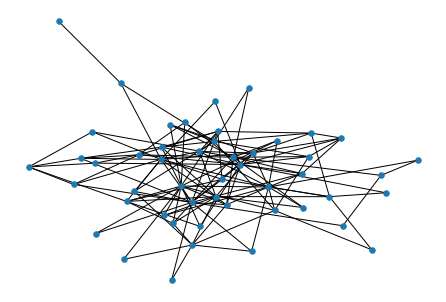

{'LCC': 49,
 'claw_count': 2442.0,
 'cpl': 2.375,
 'd': 5.469387755102041,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.30307645446238185,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6663365201758968,
 'rel_edge_distr_entropy': 0.9512566155422643,
 'square_count': 2,
 'triangle_count': 36,
 'wedge_count': 903.0}
[1860/2000]: vae_loss:1.6917, prior_loss:0.0000
max tensor(0.1062, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0834, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5227, 0.5235, 0.5216,  ..., 0.5227, 0.5227, 0.5227],
        [0.5235, 0.5244, 0.5223,  ..., 0.5235, 0.5235, 0.5235],
        [0.5216, 0.5223, 0.5211,  ..., 0.5216, 0.5216, 0.5216],
        ...,
        [0.5227, 0.5235, 0.5216,  ..., 0.5227, 0.5227, 0.5227],
        [0.5227, 0.5235, 0.5216,  ..., 0.5227, 0.5226, 0.5227],
        [0.5227, 0.5235, 0.5216,  ..., 0.5227, 0.5227, 0.5227]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


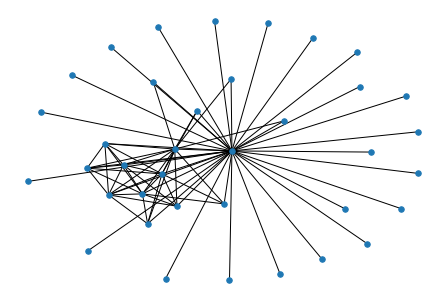

{'LCC': 37,
 'claw_count': 8034.0,
 'cpl': 1.8888888888888888,
 'd': 4.0,
 'd_max': 36.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.539810080350621,
 'n_components': 1,
 'node_num': 37,
 'power_law_exp': 2.3674789817192594,
 'rel_edge_distr_entropy': 0.8023276126006436,
 'square_count': 105,
 'triangle_count': 93,
 'wedge_count': 964.0}


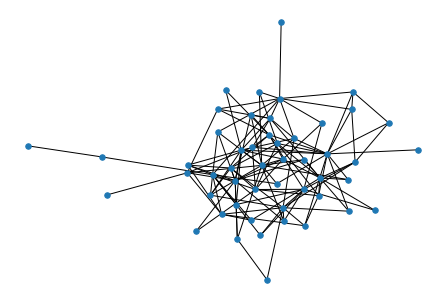

{'LCC': 50,
 'claw_count': 2180.0,
 'cpl': 2.4359183673469387,
 'd': 5.32,
 'd_max': 14.0,
 'd_min': 1.0,
 'edge_num': 133,
 'gini': 0.3030075187969925,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.6846657629533213,
 'rel_edge_distr_entropy': 0.9514991083692468,
 'square_count': 1,
 'triangle_count': 38,
 'wedge_count': 859.0}
[1890/2000]: vae_loss:1.6917, prior_loss:0.0000
max tensor(0.1069, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0843, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5228, 0.5236, 0.5213,  ..., 0.5228, 0.5230, 0.5235],
        [0.5236, 0.5245, 0.5220,  ..., 0.5236, 0.5239, 0.5244],
        [0.5213, 0.5220, 0.5212,  ..., 0.5213, 0.5215, 0.5220],
        ...,
        [0.5228, 0.5236, 0.5213,  ..., 0.5228, 0.5230, 0.5235],
        [0.5230, 0.5239, 0.5215,  ..., 0.5230, 0.5233, 0.5238],
        [0.5235, 0.5244, 0.5220,  ..., 0.5235, 0.5238, 0.5243]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


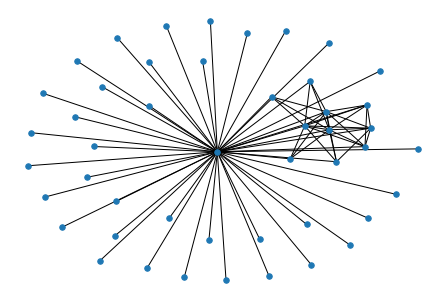

{'LCC': 47,
 'claw_count': 15637.0,
 'cpl': 1.93154486586494,
 'd': 3.148936170212766,
 'd_max': 46.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.555779183438758,
 'n_components': 1,
 'node_num': 47,
 'power_law_exp': 3.1330528708255705,
 'rel_edge_distr_entropy': 0.762663728813828,
 'square_count': 57,
 'triangle_count': 63,
 'wedge_count': 1249.0}


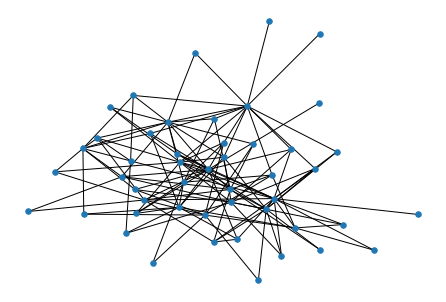

{'LCC': 48,
 'claw_count': 2674.0,
 'cpl': 2.3439716312056738,
 'd': 5.416666666666667,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 130,
 'gini': 0.32788461538461555,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.6901556306641492,
 'rel_edge_distr_entropy': 0.9427817301797886,
 'square_count': 1,
 'triangle_count': 46,
 'wedge_count': 917.0}
[1920/2000]: vae_loss:1.7152, prior_loss:0.0000
max tensor(0.1161, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0859, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5224, 0.5224, 0.5243,  ..., 0.5225, 0.5227, 0.5225],
        [0.5224, 0.5224, 0.5242,  ..., 0.5225, 0.5226, 0.5225],
        [0.5243, 0.5242, 0.5290,  ..., 0.5243, 0.5246, 0.5243],
        ...,
        [0.5225, 0.5225, 0.5243,  ..., 0.5226, 0.5228, 0.5226],
        [0.5227, 0.5226, 0.5246,  ..., 0.5228, 0.5230, 0.5228],
        [0.5225, 0.5225, 0.5243,  ..., 0.5226, 0.5228, 0.5226]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


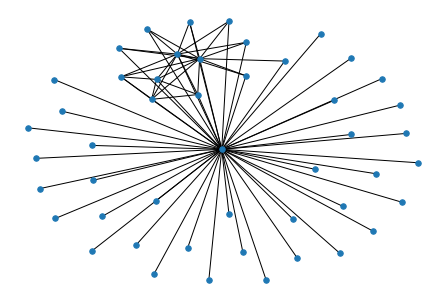

{'LCC': 48,
 'claw_count': 16787.0,
 'cpl': 1.9343971631205674,
 'd': 3.0833333333333335,
 'd_max': 47.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.5523648648648649,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 3.088116853334659,
 'rel_edge_distr_entropy': 0.7622218119874918,
 'square_count': 31,
 'triangle_count': 49,
 'wedge_count': 1294.0}


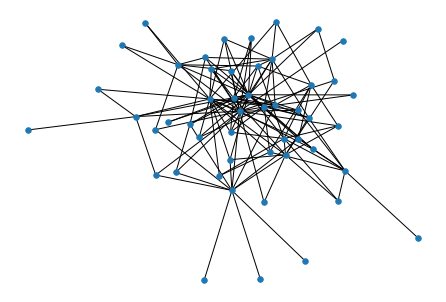

{'LCC': 50,
 'claw_count': 3945.0,
 'cpl': 2.3379591836734694,
 'd': 5.36,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3664179104477612,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7207151041015585,
 'rel_edge_distr_entropy': 0.9290919405294922,
 'square_count': 2,
 'triangle_count': 43,
 'wedge_count': 1062.0}
[1950/2000]: vae_loss:1.5272, prior_loss:0.0000
max tensor(0.0995, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0862, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5226, 0.5226, 0.5235,  ..., 0.5226, 0.5228, 0.5232],
        [0.5226, 0.5226, 0.5235,  ..., 0.5226, 0.5228, 0.5232],
        [0.5235, 0.5235, 0.5245,  ..., 0.5235, 0.5237, 0.5241],
        ...,
        [0.5226, 0.5226, 0.5235,  ..., 0.5226, 0.5228, 0.5232],
        [0.5228, 0.5228, 0.5237,  ..., 0.5228, 0.5230, 0.5234],
        [0.5232, 0.5232, 0.5241,  ..., 0.5232, 0.5234, 0.5239]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


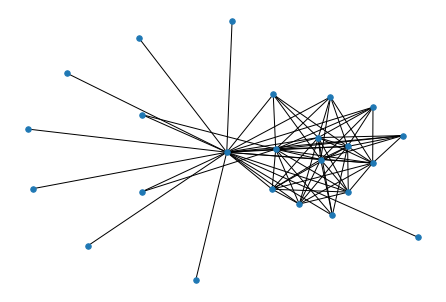

{'LCC': 24,
 'claw_count': 3497.0,
 'cpl': 1.7246376811594204,
 'd': 6.333333333333333,
 'd_max': 23.0,
 'd_min': 1.0,
 'edge_num': 76,
 'gini': 0.39583333333333326,
 'n_components': 1,
 'node_num': 24,
 'power_law_exp': 1.7463832836217115,
 'rel_edge_distr_entropy': 0.8766023783105904,
 'square_count': 206,
 'triangle_count': 151,
 'wedge_count': 798.0}


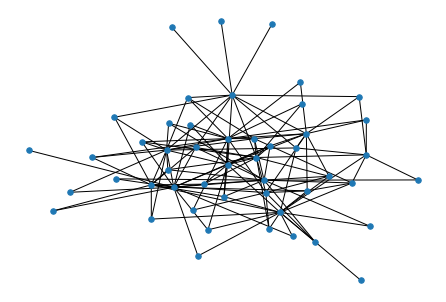

{'LCC': 49,
 'claw_count': 3761.0,
 'cpl': 2.310374149659864,
 'd': 5.428571428571429,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 133,
 'gini': 0.3874482123676537,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7307006410223904,
 'rel_edge_distr_entropy': 0.9217945423642026,
 'square_count': 1,
 'triangle_count': 55,
 'wedge_count': 1088.0}
[1980/2000]: vae_loss:1.6682, prior_loss:0.0000
max tensor(0.1028, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(0.0868, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5227, 0.5233, 0.5238,  ..., 0.5226, 0.5227, 0.5231],
        [0.5233, 0.5239, 0.5245,  ..., 0.5232, 0.5233, 0.5238],
        [0.5238, 0.5245, 0.5257,  ..., 0.5238, 0.5238, 0.5244],
        ...,
        [0.5226, 0.5232, 0.5238,  ..., 0.5226, 0.5226, 0.5231],
        [0.5227, 0.5233, 0.5238,  ..., 0.5226, 0.5227, 0.5231],
        [0.5231, 0.5238, 0.5244,  ..., 0.5231, 0.5231, 0.5236]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


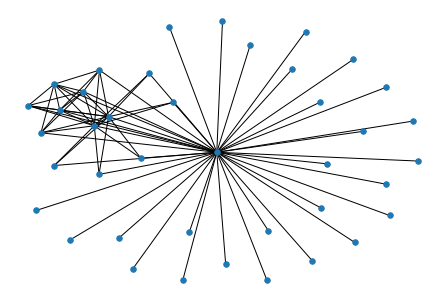

{'LCC': 40,
 'claw_count': 9944.0,
 'cpl': 1.905128205128205,
 'd': 3.7,
 'd_max': 39.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.5483108108108108,
 'n_components': 1,
 'node_num': 40,
 'power_law_exp': 2.544394100474636,
 'rel_edge_distr_entropy': 0.7901366261524478,
 'square_count': 80,
 'triangle_count': 80,
 'wedge_count': 1041.0}


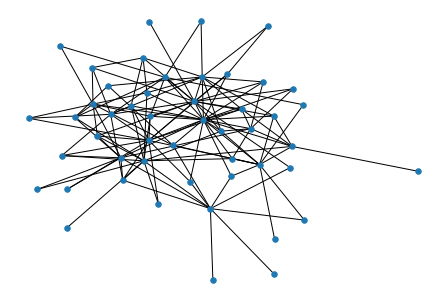

{'LCC': 49,
 'claw_count': 3780.0,
 'cpl': 2.3639455782312924,
 'd': 5.469387755102041,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.37389582698751145,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.718661928146608,
 'rel_edge_distr_entropy': 0.9275875987353714,
 'square_count': 2,
 'triangle_count': 56,
 'wedge_count': 1070.0}


In [97]:
## Implement VAE/GAE Here to check the results

av_size = 0  # set 0 if you do not need attr_vec
# d_size = 8
#z_size = 64
#gc_size = 16
d_size = 50 #16
z_size =2
gc_size = 16
rep_size = 16
z_out_size = z_size + av_size

adj_thresh = .5
max_epochs = 2000
lr = 0.001


beta = 5
alpha = 0.1
gamma = 15

G = Generator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size,
    z_size=z_size,
    z_out_size=z_out_size,
    rep_size=rep_size
).cuda()
'''
D = Discriminator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size
).cuda()
'''
criterion_bce = nn.BCELoss()
criterion_bce.cuda()

loss_MSE = nn.MSELoss()
loss_MSE.cuda()   
loss_BCE = nn.BCELoss()
loss_BCE.cuda()      
  
for name, param in G.named_parameters():
	print(name, '      ', param.size())
# I won't use the next 3 lines
opt_enc = optim.RMSprop(G.encoder.parameters(), lr=lr)
opt_dec = optim.RMSprop(G.decoder.parameters(), lr=lr)
#opt_dis = optim.RMSprop(D.parameters(), lr=lr * alpha)

#opt_vae = optim.RMSprop(G.parameters(), lr=lr)
opt_vae = optim.Adam(G.parameters(), lr=lr)


for epoch in range(max_epochs):
    D_real_list, D_rec_enc_list, D_rec_noise_list, D_list = [], [], [], []
    # g_loss_list, rec_loss_list, prior_loss_list = [], [], []
    g_loss_list, rec_loss_list, prior_loss_list, aa_loss_list = [], [], [], []
    # for i in range(len(t_adj_mats)):
    # Only train the 8th graph
    for i in range(8, 9): 
        
        ones_label = Variable(torch.ones(1)).cuda()
        zeros_label = Variable(torch.zeros(1)).cuda()
        edge_num = t_adj_mats[i].sum()
        adj = Variable(t_adj_mats[i]).cuda()
        #if adj.shape[0] <= d_size:
        #    continue
            
        if av_size == 0:
            attr_vec = None
        else:
            attr_vec = Variable(t_attr_vecs[i, :]).cuda()
        
        G.set_attr_vec(attr_vec)
        #D.set_attr_vec(attr_vec)
        
        norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
        pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
        # print('pos_weight', pos_weight)
        mean, logvar, rec_adj = G(adj, training=True)
        
        noisev = torch.randn(mean.shape, requires_grad=True).cuda()
        noisev = cat_attr(noisev, attr_vec)
        rec_noise = G.decoder(noisev)
        '''
        # train discriminator
        output = D(adj)
        errD_real = criterion_bce(output, ones_label)
        D_real_list.append(output.data.mean())
        output = D(rec_adj)
        errD_rec_enc = criterion_bce(output, zeros_label)
        D_rec_enc_list.append(output.data.mean())
        output = D(rec_noise)
        errD_rec_noise = criterion_bce(output, zeros_label)
        D_rec_noise_list.append(output.data.mean())
        
        dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise
        # print ("print (dis_img_loss)", dis_img_loss)
        D_list.append(dis_img_loss.data.mean())
        opt_dis.zero_grad()
        dis_img_loss.backward(retain_graph=True)
        opt_dis.step()
        '''
        loss_BCE_logits = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss_BCE_logits.cuda() 
        
        # AA_loss b/w rec_adj and adj
        # aa_loss = loss_MSE(rec_adj, adj)
        # aa_loss = loss_BCE_logits(rec_adj, adj)
        #b_adj=F.sigmoid(rec_adj)
        #b_adj[F.sigmoid(rec_adj)<=0.6] =0
        #c_adj = sample_adj(b_adj)
        
        c_adj = topk_adj(F.sigmoid(rec_adj), int(edge_num.numpy()))
        aa_loss = loss_BCE(c_adj, adj)
        
        # fix me: sum version of prior loss
        pl = []
        for i in range(mean.size()[0]):
            prior_loss = 1 + logvar[i, :] - mean[i, :].pow(2) - logvar[i, :].exp()
            prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean[i, :].data)
            pl.append(prior_loss)
        prior_loss_list.append(sum(pl))
        kl_loss = sum(pl)/torch.numel(mean[i, :].data)
        vae_loss = kl_loss + norm*aa_loss
        opt_vae.zero_grad()
        vae_loss.backward() #retain_graph=True
        opt_vae.step()
        
    if epoch % 30 == 0:   
        _,_, rec_adj = G(adj, training=False)
        b_adj=F.sigmoid(rec_adj)
        #b_adj[F.sigmoid(rec_adj)] =0
        c_adj = sample_adj(b_adj)
        
        print('[%d/%d]: vae_loss:%.4f, prior_loss:%.4f' 
               % (epoch, 
                  max_epochs, 
                  torch.mean(torch.stack([vae_loss])),
                  torch.mean(torch.stack(prior_loss_list))))

        print('max',(rec_adj.max()),'min',(rec_adj.min()))
       
        print('rec_adj w/ sigmoid', F.sigmoid(rec_adj))
        #148
        # print(edge_num.numpy(),'edge_num')
        show_graph(topk_adj(F.sigmoid(rec_adj), int(edge_num.numpy()) ), thresh=adj_thresh)
        show_graph(topk_adj(c_adj, int(edge_num.numpy())), thresh=0)


In [0]:
av_size = 0  # set 0 if you do not need attr_vec
# d_size = 8
#z_size = 64
#gc_size = 16
d_size = 16
z_size = 16
gc_size = 32
z_out_size = z_size + av_size
rep_size = 32

adj_thresh = .7
max_epochs = 1000
lr = 3e-4


beta = 5
alpha = 0.1
gamma = 15

G = Generator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size,
    z_size=z_size,
    z_out_size=z_out_size,
    rep_size=rep_size
).cuda()

D = Discriminator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size
).cuda()

criterion_bce = nn.BCELoss()
criterion_bce.cuda()

loss_MSE = nn.MSELoss()
loss_MSE.cuda()      
loss_BCE = nn.BCEWithLogitsLoss()#size_average=False)
loss_BCE.cuda()      


# loss for A and A'
# todo: add the loss to main
criterion_bcell = nn.BCEWithLogitsLoss()
criterion_bcell.cuda()


opt_enc = optim.RMSprop(G.encoder.parameters(), lr=lr)
opt_dec = optim.RMSprop(G.decoder.parameters(), lr=lr)
opt_dis = optim.RMSprop(D.parameters(), lr=lr * alpha)

for epoch in range(max_epochs):
    D_real_list, D_rec_enc_list, D_rec_noise_list, D_list = [], [], [], []
    # g_loss_list, rec_loss_list, prior_loss_list = [], [], []
    g_loss_list, rec_loss_list, prior_loss_list, aa_loss_list = [], [], [], []
    # for i in range(len(t_adj_mats)):
    # Only train the 8th graph
    for i in range(8, 9): 
        ones_label = Variable(torch.ones(1)).cuda()
        zeros_label = Variable(torch.zeros(1)).cuda()
        
        adj = Variable(t_adj_mats[i]).cuda()
        if adj.shape[0] <= d_size:
            continue
            
        if av_size == 0:
            attr_vec = None
        else:
            attr_vec = Variable(t_attr_vecs[i, :]).cuda()
        
        G.set_attr_vec(attr_vec)
        D.set_attr_vec(attr_vec)
        
        mean, logvar, rec_adj = G(adj)
        
        noisev = torch.randn(mean.shape, requires_grad=True).cuda()
        noisev = cat_attr(noisev, attr_vec)
        rec_noise = G.decoder(noisev)
        
        # train discriminator
        output = D(adj)
        errD_real = criterion_bce(output, ones_label)
        D_real_list.append(output.data.mean())
        output = D(rec_adj)
        errD_rec_enc = criterion_bce(output, zeros_label)
        D_rec_enc_list.append(output.data.mean())
        output = D(rec_noise)
        errD_rec_noise = criterion_bce(output, zeros_label)
        D_rec_noise_list.append(output.data.mean())
        
        dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise
        # print ("print (dis_img_loss)", dis_img_loss)
        D_list.append(dis_img_loss.data.mean())
        opt_dis.zero_grad()
        dis_img_loss.backward(retain_graph=True)
        opt_dis.step()
        
        
        # AA_loss b/w rec_adj and adj
        #aa_loss = loss_MSE(rec_adj, adj)
        aa_loss = loss_BCE(rec_adj, adj)
        
        # train decoder
        output = D(adj)
        errD_real = criterion_bce(output, ones_label)
        output = D(rec_adj)
        errD_rec_enc = criterion_bce(output, zeros_label)
        output = D(rec_noise)
        errD_rec_noise = criterion_bce(output, zeros_label)
        
        similarity_rec_enc = D.similarity(rec_adj)
        similarity_data = D.similarity(adj)
        
        dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise 
        # print (dis_img_loss)
        gen_img_loss = aa_loss + errD_rec_enc # - dis_img_loss 
        
        g_loss_list.append(gen_img_loss.data.mean())
        rec_loss = ((similarity_rec_enc - similarity_data) ** 2).mean()
        rec_loss_list.append(rec_loss.data.mean())
        err_dec = gamma * rec_loss + gen_img_loss
        
        opt_dec.zero_grad()
        err_dec.backward(retain_graph=True)
        opt_dec.step()
        
        # train encoder
        # fix me: sum version of prior loss
        pl = []
        for i in range(mean.size()[0]):
            prior_loss = 1 + logvar[i, :] - mean[i, :].pow(2) - logvar[i, :].exp()
            prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean[i, :].data)
            pl.append(prior_loss)
        prior_loss_list.append(sum(pl))
        err_enc = sum(pl) + beta * rec_loss
        
        opt_enc.zero_grad()
        err_enc.backward()
        opt_enc.step()
    if epoch % 50 == 0:   
        print('[%d/%d]: D_real:%.4f, D_enc:%.4f, D_noise:%.4f, Loss_D:%.4f, Loss_G:%.4f, rec_loss:%.4f, prior_loss:%.4f' 
               % (epoch, 
                  max_epochs, 
                  torch.mean(torch.stack(D_real_list)), 
                  torch.mean(torch.stack(D_rec_enc_list)), 
                  torch.mean(torch.stack(D_rec_noise_list)), 
                  torch.mean(torch.stack(D_list)), 
                  torch.mean(torch.stack(g_loss_list)),
                  torch.mean(torch.stack(rec_loss_list)),
                  torch.mean(torch.stack(prior_loss_list))))
        print(F.sigmoid(rec_adj).cpu())
        show_graph(F.sigmoid(rec_adj), thresh=adj_thresh)
        
        #show_graph(rec_adj, thresh=adj_thresh)


In [0]:
def test_gen(model, n, attr_vec):
    fixed_noise = torch.randn((n, z_size), requires_grad=True).cuda()
    if attr_vec:
        fixed_noise = cat_attr(fixed_noise, attr_vec.cuda())
    a_ = model.decoder(fixed_noise)
    show_graph(F.sigmoid(a_), thresh=.53)

for _ in range(5):
    test_gen(G, 40, None)

# for _ in range(5):
#     test_gen(G, 10, t_attr_vecs[1, :])
    

In [0]:
print(G)
print(D)